<a href="https://colab.research.google.com/github/ArthurRodriguesEng/processos_estocaticos_final/blob/main/Trabalho_final_processos_estoc%C3%A1sticos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Informações iniciais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23769 entries, 0 to 23768
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              23769 non-null  object 
 1   poa_irradiancia       23769 non-null  float64
 2   vel_vento             23768 non-null  float64
 3   ghi_irradiancia       23769 non-null  float64
 4   gri_irradiancia       23768 non-null  float64
 5   temperatura_painel    23768 non-null  float64
 6   temperatura_ambiente  23768 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.3+ MB

Primeiras linhas dos dados:
                   datetime  poa_irradiancia  vel_vento  ghi_irradiancia  \
0  2024-11-01T03:03:04.974Z            -2.08      4.158            -2.26   
1  2024-11-01T03:07:10.631Z            -1.83      4.874            -2.15   
2  2024-11-01T03:11:16.696Z            -1.97      4.970            -2.25   
3  2024-11-0

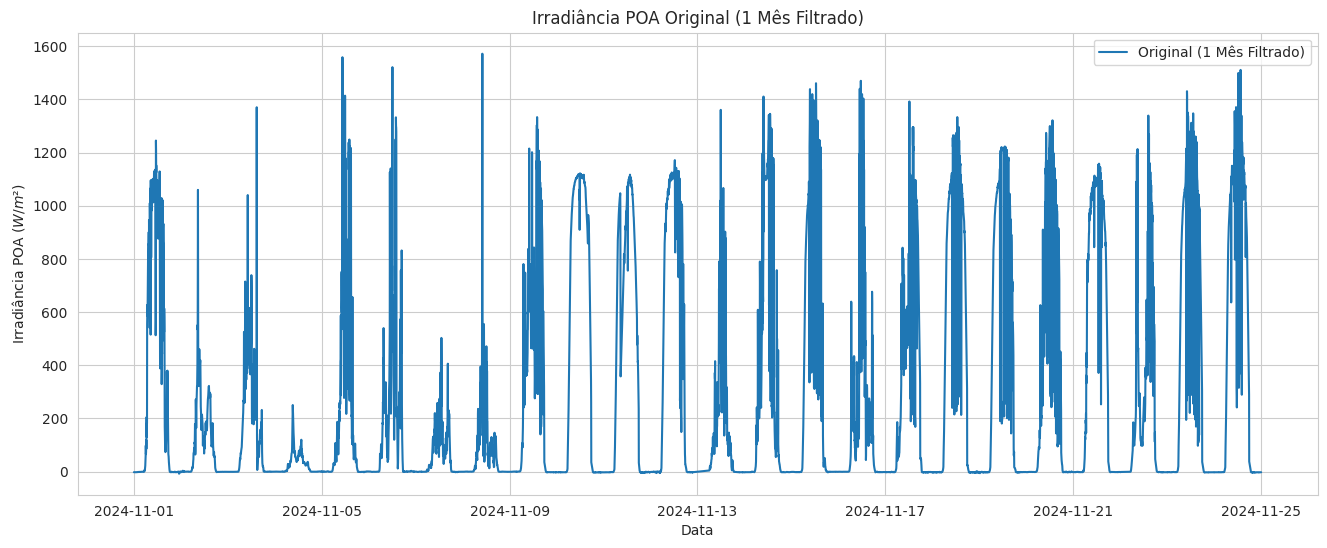


[Passo 2.1] Preparando dados para Modelagem como Processo Estocástico:
  - Valores negativos substituídos por 0.

  - Série reamostrada para 10 em 10 minutos. Total de 3456 pontos.
  - Imputando NaNs com a média histórica do mesmo horário em outros dias...
  - NaNs imputados com a média histórica por horário. Série final para análise tem 3456 pontos.
  - Número de NaNs restantes: 0

[Passo 2.1] Preparação de dados para Modelagem como Processo Estocástico concluída.


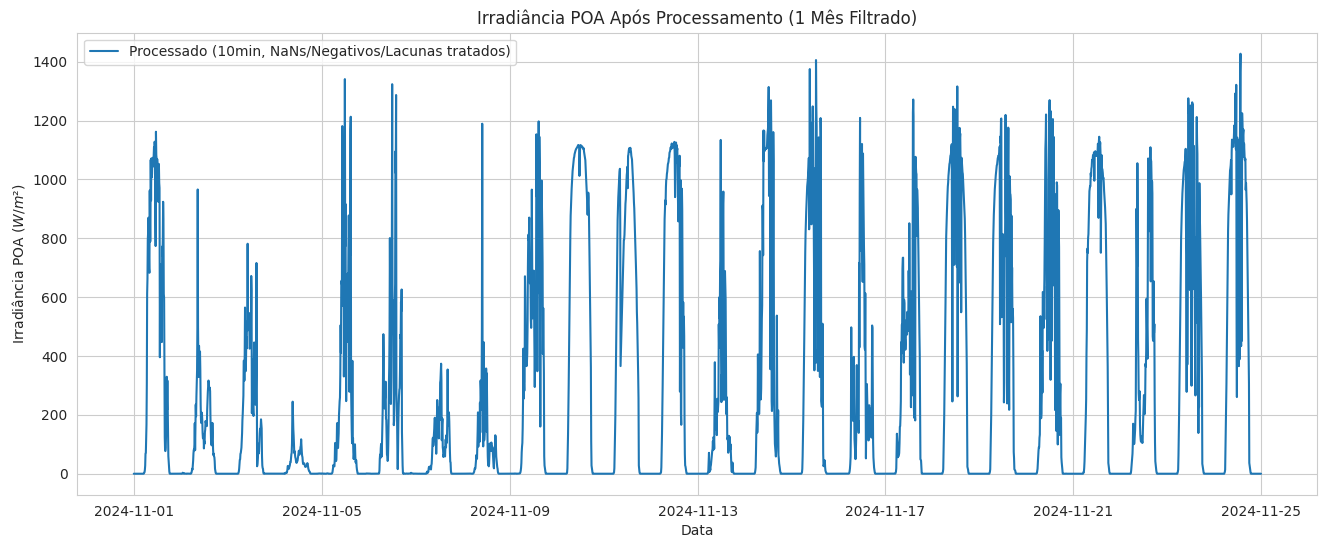

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import matplotlib.dates as mdates # Importar mdates

warnings.filterwarnings("ignore")

# Configurações de plotagem para melhor visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# Carregar os dados
# Corrigir o nome do arquivo CSV
df = pd.read_csv('/content/ribeirao est solar..csv')

# --- ETAPA COMUM: Pré-processamento Inicial ---
print("\nInformações iniciais do DataFrame:")
df.info()
print("\nPrimeiras linhas dos dados:")
print(df.head())

# Converter 'datetime' para o formato datetime e tratar erros
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Remover linhas onde a conversão de data falhou
df.dropna(subset=['datetime'], inplace=True)

# Definir datetime como índice
df.set_index('datetime', inplace=True)

# Remover índices duplicados se existirem
if not df.index.is_unique:
    print("\nÍndices duplicados encontrados. Removendo linhas com índices duplicados...")
    df = df[~df.index.duplicated(keep='first')]
    print("Linhas com índices duplicados removidas.")

# Ajustar fuso horário para GMT-3
# Primeiro, remove o fuso horário se já existir
df.index = df.index.tz_convert(None)
# Em seguida, define o fuso horário como UTC (pois os dados originais estão em Z)
df.index = df.index.tz_localize('UTC')
# Finalmente, converte para o fuso horário desejado (GMT-3)
df.index = df.index.tz_convert('Etc/GMT+3') # Note: GMT+X in pandas/pytz is UTC-X

print("\nFuso horário ajustado para GMT-3.")
print("\nPrimeiras linhas do DataFrame após ajuste de fuso horário:")
print(df.head())


print("\nPré-processamento inicial concluído. DataFrame 'df' pronto para análise.")

# --- FILTRAR PARA UM MÊS ESPECÍFICO ---
# Obter o primeiro e último dia do primeiro mês nos dados
start_date = df.index.min().replace(day=1, hour=0, minute=0, second=0, microsecond=0)
# Calcular a data do último dia do primeiro mês + 1 dia para incluir 00:00 do último dia
end_date = (start_date + pd.DateOffset(days=24)).replace(hour=0, minute=0, second=0, microsecond=0)


print(f"\nFiltrando dados para o período de {start_date.strftime('%Y-%m-%d %H:%M')} a {(end_date - pd.Timedelta(minutes=1)).strftime('%Y-%m-%d %H:%M')}")

# Aplicar o filtro
df = df.loc[start_date:end_date - pd.Timedelta(minutes=1)].copy() # Usar copy() para evitar SettingWithCopyWarning

print(f"\nDados filtrados. Total de {len(df)} pontos no período de um mês.")
print("\nPrimeiras linhas dos dados filtrados:")
print(df.head())
print("\nÚltimas linhas dos dados filtrados:")
print(df.tail())


# --- PREPARAÇÃO DE DATA PARA MODELAGEM COMO PROCESSO ESTOCÁSTICO ---
print("\n" + "="*50)
print("--- PREPARANDO DADOS PARA MODELAGEM COMO PROCESSO ESTOCÁSTICO ---")
print("="*50)

# Plotar dados originais antes do processamento (agora filtrados)
plt.figure(figsize=(16, 6))
plt.plot(df['poa_irradiancia'], label='Original (1 Mês Filtrado)')
plt.title('Irradiância POA Original (1 Mês Filtrado)')
plt.xlabel('Data')
plt.ylabel('Irradiância POA ($W/m²$)')
plt.legend()
plt.show()


print("\n[Passo 2.1] Preparando dados para Modelagem como Processo Estocástico:")

# 1. Tratar valores negativos: Substituir por 0 ANTES da reamostragem
poa_cleaned = df['poa_irradiancia'].copy()
poa_cleaned[poa_cleaned < 0] = 0
print("  - Valores negativos substituídos por 0.")

# 2. Reamostrar para intervalos de 10 em 10 minutos
# Usamos mean() para agregar múltiplos pontos dentro de um intervalo de 10 minutos, se houver (improvável)
poa_10min = poa_cleaned.resample('10Min').mean()
print(f"\n  - Série reamostrada para 10 em 10 minutos. Total de {len(poa_10min)} pontos.")


# 3. Imputar NaNs com a média histórica do mesmo horário em outros dias
print("  - Imputando NaNs com a média histórica do mesmo horário em outros dias...")

# Criar colunas de hora e minuto para agrupar
temp_df = poa_10min.reset_index()
temp_df['hour_minute'] = temp_df['datetime'].dt.strftime('%H:%M')

# Calcular a média para cada hora:minuto ao longo de todos os dias
mean_by_time = temp_df.groupby('hour_minute')['poa_irradiancia'].mean()

# Mapear as médias de volta para a série original de 10 minutos para preencher NaNs
# Precisamos alinhar o índice 'datetime' da série original com a 'hour_minute' da média
# A melhor forma é criar uma série com as médias históricas alinhadas pelo tempo de cada ponto na série original
imputation_values = poa_10min.index.to_series().dt.strftime('%H:%M').map(mean_by_time)
imputation_values.index = poa_10min.index # Alinhar índices de volta

# Preencher NaNs na série de 10 minutos usando esses valores de imputação
poa_hourly = poa_10min.fillna(imputation_values)

# Para quaisquer NaNs remanescentes (ex: se um horário específico só tiver NaNs), usar uma imputação final (ex: média global)
poa_hourly = poa_hourly.fillna(poa_hourly.mean())

print(f"  - NaNs imputados com a média histórica por horário. Série final para análise tem {len(poa_hourly)} pontos.")

# Verificar se ainda há NaNs
print(f"  - Número de NaNs restantes: {poa_hourly.isnull().sum()}")

# Criar a variável subset_data que é usada nas células subsequentes
subset_data = poa_hourly.copy()

print("\n[Passo 2.1] Preparação de dados para Modelagem como Processo Estocástico concluída.")

# Plotar dados depois do processamento
plt.figure(figsize=(16, 6))
plt.plot(subset_data, label='Processado (10min, NaNs/Negativos/Lacunas tratados)')
plt.title('Irradiância POA Após Processamento (1 Mês Filtrado)')
plt.xlabel('Data')
plt.ylabel('Irradiância POA ($W/m²$)')
plt.legend()
plt.show()


--- INICIANDO ANÁLISE: DISTRIBUIÇÃO DOS DADOS HORÁRIOS IMPUTADOS ---

[Passo 1.1] Dados utilizados para análise de distribuição: Série Temporal Horária Imputada. Total de 2157 pontos.

[Passo 1.1] Gráfico 'distribuicao_dados_imputados_histograma.png' salvo com o histograma dos dados imputados (> 0).

[Passo 1.2] Ajustando distribuições de probabilidade (Gamma, Log-Normal, Weibull) aos dados horários imputados...

  Distribuições ajustadas (Gamma e Log-Normal ajustadas aos valores > 0).

[Passo 1.3] Avaliando a qualidade do ajuste (Teste Kolmogorov-Smirnov) usando TODOS os dados imputados:

  Resultados do Teste Kolmogorov-Smirnov (quanto maior o p-value, melhor):
  - Gamma:      Estatística=0.3965, p-value=0.0000
  - Log-Normal: Estatística=0.4058, p-value=0.0000
  - Weibull:    Estatística=0.4579, p-value=0.0000

[Passo 1.3] Gráfico 'distribuicao_dados_imputados_ajuste.png' salvo com as curvas de distribuição ajustadas para frequência.

[Passo 1.4] Gerando Q-Q plots para avaliar o aj

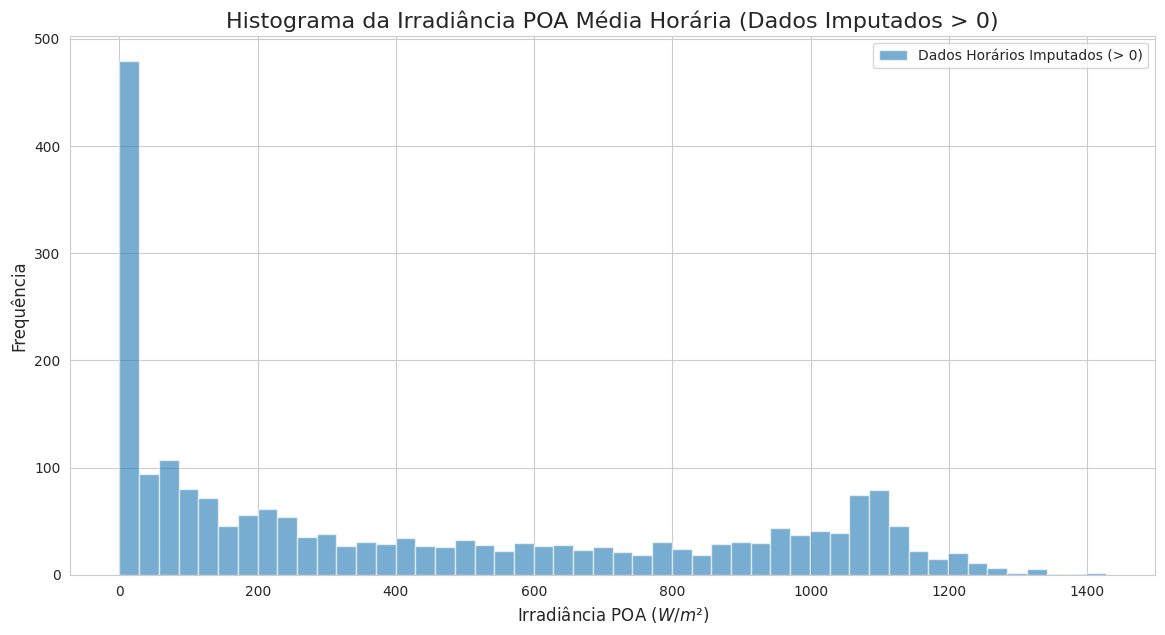

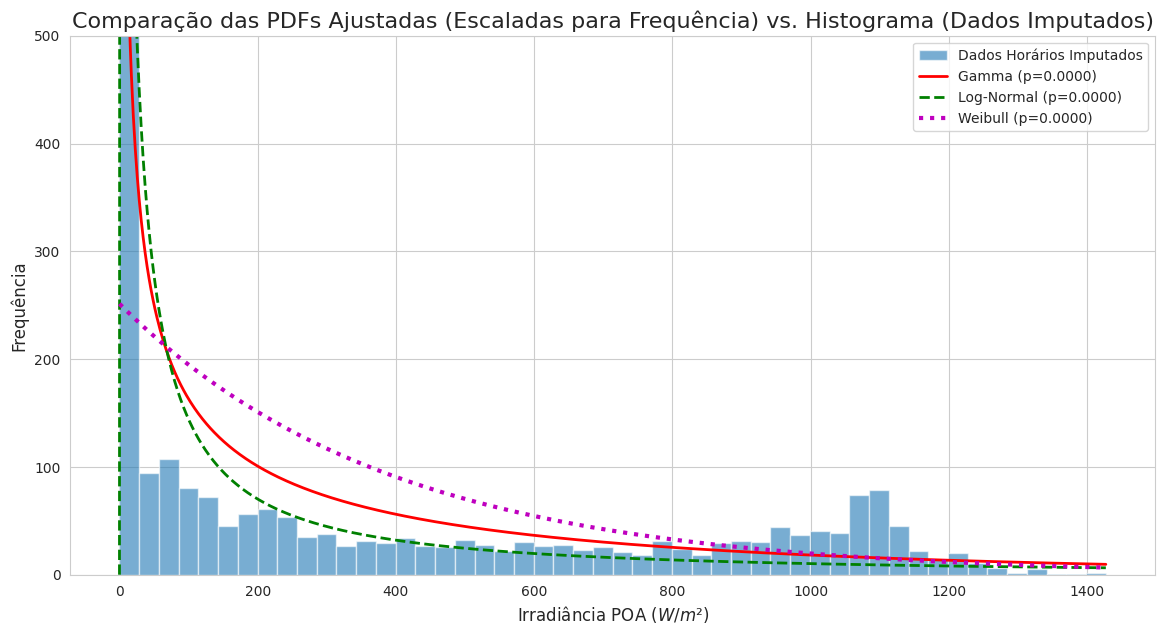

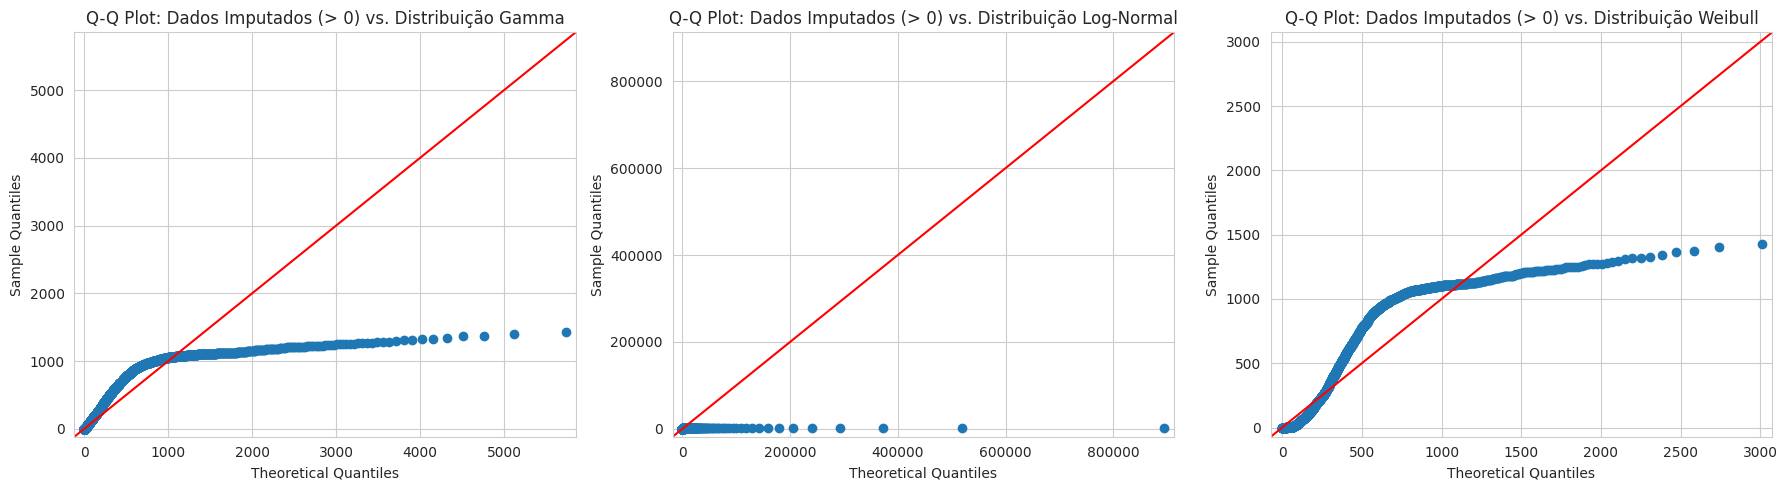

In [ ]:
# --- ANÁLISE DE DISTRIBUIÇÃO DOS DADOS HORÁRIOS IMPUTADOS (Similar ao Caso 1, usando input do Caso 2) ---
print("\n" + "="*50)
print("--- INICIANDO ANÁLISE: DISTRIBUIÇÃO DOS DADOS HORÁRIOS IMPUTADOS ---")
print("="*50)

# Os dados de entrada para esta análise são 'subset_data', preparados na célula MRwRfTxPROhR.
# 'subset_data' é a série temporal horária completa, com imputação de média horária para NaNs e negativos=0.
data_to_analyze = subset_data.copy()
subset_data_positive = data_to_analyze[data_to_analyze > 0].dropna()
# Assumimos que 'subset_data' já foi criado e está disponível.
if 'subset_data' not in locals() and 'subset_data' not in globals():
    print("\nErro: A variável 'subset_data' não foi encontrada. Por favor, execute a célula MRwRfTxPROhR primeiro para preparar os dados.")
else:
    #data_to_analyze = subset_data.copy()

    print(f"\n[Passo 1.1] Dados utilizados para análise de distribuição: Série Temporal Horária Imputada. Total de {len(subset_data_positive)} pontos.")

    # 1. Visualizar a distribuição
    plt.figure()
    # Histograma de frequência
    counts, bins, patches = plt.hist(subset_data_positive, bins=50, density=False, alpha=0.6, label='Dados Horários Imputados (> 0)') # Modify to use subset_data_positive
    plt.title('Histograma da Irradiância POA Média Horária (Dados Imputados > 0)', fontsize=16) # Update title
    plt.xlabel('Irradiância POA ($W/m²$)', fontsize=12)
    plt.ylabel('Frequência', fontsize=12)
    plt.legend()
    #plt.savefig('distribuicao_dados_imputados_histograma.png')
    print("\n[Passo 1.1] Gráfico 'distribuicao_dados_imputados_histograma.png' salvo com o histograma dos dados imputados (> 0).") # Update print message


    # 2. Ajustar distribuições
    print("\n[Passo 1.2] Ajustando distribuições de probabilidade (Gamma, Log-Normal, Weibull) aos dados horários imputados...")
    if len(data_to_analyze) > 10: # Certificar que há dados suficientes para o ajuste
        # Ajustar distribuições aos dados imputados (incluem zeros)
        # Para distribuições como Log-Normal e Gamma (tipicamente para > 0),
        # ajustar a dados com zeros pode levar a parâmetros incomuns ou erros
        # se floc=0 não for usado. Vamos tentar com floc=0 para manter a irradiação >= 0.

        # Para Gamma e Log-Normal, ajustar APENAS aos valores > 0
        subset_data_positive = data_to_analyze[data_to_analyze > 0].dropna()

        if len(subset_data_positive) > 10:
            params_gamma = stats.gamma.fit(subset_data_positive, floc=0) # floc=0 pois irradiação não é negativa
            params_lognorm = stats.lognorm.fit(subset_data_positive, floc=0) # floc=0 para log-normal
            # Para Weibull (Exponweib), podemos ajustar a todos os dados com floc=0
            params_weibull = stats.exponweib.fit(data_to_analyze, floc=0) # floc=0 para weibull
            params_weibull0 = stats.exponweib.fit(subset_data_positive, floc=0) # floc=0 para weibull

            print("\n  Distribuições ajustadas (Gamma e Log-Normal ajustadas aos valores > 0).")

            # 3. Avaliar a qualidade do ajuste (KS) - Usando TODOS os dados imputados para o teste
            print("\n[Passo 1.3] Avaliando a qualidade do ajuste (Teste Kolmogorov-Smirnov) usando TODOS os dados imputados:")

            # Teste Kolmogorov-Smirnov nos dados COMPLETOS imputados
            # Para distribuições ajustadas apenas aos dados > 0, o teste KS pode não ser diretamente aplicável
            # ou pode exigir uma adaptação para lidar com a massa de probabilidade em zero.
            # No entanto, vamos executar o teste padrão para comparação inicial.
            ks_gamma = stats.kstest(data_to_analyze, 'gamma', args=params_gamma)
            ks_lognorm = stats.kstest(data_to_analyze, 'lognorm', args=params_lognorm)
            ks_weibull = stats.kstest(data_to_analyze, 'exponweib', args=params_weibull)
            ks_weibull0 = stats.kstest(subset_data_positive, 'exponweib', args=params_weibull)

            print("\n  Resultados do Teste Kolmogorov-Smirnov (quanto maior o p-value, melhor):")
            print(f"  - Gamma:      Estatística={ks_gamma.statistic:.4f}, p-value={ks_gamma.pvalue:.4f}")
            print(f"  - Log-Normal: Estatística={ks_lognorm.statistic:.4f}, p-value={ks_lognorm.pvalue:.4f}")
            print(f"  - Weibull:    Estatística={ks_weibull.statistic:.4f}, p-value={ks_weibull.pvalue:.4f}")


            # Plotar PDFs sobre o histograma (ajustado para frequência)
            plt.figure()
            # Plotar histograma de frequência novamente para sobrepor as PDFs
            counts, bins, patches = plt.hist(data_to_analyze, bins=50, density=False, alpha=0.6, label='Dados Horários Imputados')
            bin_width = bins[1] - bins[0]
            total_count = len(data_to_analyze)

            x_vals = np.linspace(data_to_analyze.min(), data_to_analyze.max(), 1000)

            # Escalar PDFs para corresponder à frequência do histograma
            # Cuidado ao plotar PDFs de distribuições > 0 sobre dados com massa em zero.
            # As PDFs serão 0 para x <= loc.

            plt.plot(x_vals, stats.gamma.pdf(x_vals, *params_gamma) * total_count * bin_width, 'r-', lw=2, label=f'Gamma (p={ks_gamma.pvalue:.4f})')
            plt.plot(x_vals, stats.lognorm.pdf(x_vals, params_lognorm[0], loc=params_lognorm[1], scale=params_lognorm[2]) * total_count * bin_width, 'g--', lw=2, label=f'Log-Normal (p={ks_lognorm.pvalue:.4f})')
            # Para Weibull, usar exponweib.pdf
            plt.plot(x_vals, stats.exponweib.pdf(x_vals, params_weibull[0], params_weibull[1], loc=params_weibull[2], scale=params_weibull[3]) * total_count * bin_width, 'm:', lw=3, label=f'Weibull (p={ks_weibull.pvalue:.4f})')

            plt.title('Comparação das PDFs Ajustadas (Escaladas para Frequência) vs. Histograma (Dados Imputados)', fontsize=16)
            plt.xlabel('Irradiância POA ($W/m²$)', fontsize=12)
            plt.ylabel('Frequência', fontsize=12)
            plt.legend()
            plt.ylim(0, 500) # Set y-axis limit to 150
            #plt.savefig('distribuicao_dados_imputados_ajuste.png')
            print("\n[Passo 1.3] Gráfico 'distribuicao_dados_imputados_ajuste.png' salvo com as curvas de distribuição ajustadas para frequência.")


            # 4. Gerar Q-Q plots para avaliar o ajuste
            print("\n[Passo 1.4] Gerando Q-Q plots para avaliar o ajuste das distribuições nos dados imputados.")

            plt.figure(figsize=(18, 5))

            # Criar objetos de distribuição congelada com os parâmetros ajustados (dos dados > 0)
            frozen_gamma = stats.gamma(*params_gamma)
            frozen_lognorm = stats.lognorm(*params_lognorm)
            frozen_weibull = stats.exponweib(*params_weibull)


            plt.subplot(1, 3, 1)
            # Passar o objeto de distribuição congelada para sm.qqplot
            # Note: Q-Q plot comparando dados COM zeros com distribuições ajustadas SEM zeros pode não ser ideal.
            sm.qqplot(subset_data_positive, dist=frozen_gamma, line='45', ax=plt.gca()) # Modify to use subset_data_positive
            plt.title('Q-Q Plot: Dados Imputados (> 0) vs. Distribuição Gamma') # Update title

            plt.subplot(1, 3, 2)
            # Passar o objeto de distribuição congelada para sm.qqplot
            sm.qqplot(subset_data_positive, dist=frozen_lognorm, line='45', ax=plt.gca()) # Modify to use subset_data_positive
            plt.title('Q-Q Plot: Dados Imputados (> 0) vs. Distribuição Log-Normal') # Update title

            plt.subplot(1, 3, 3)
            # Passar o objeto de distribuição congelada para sm.qqplot
            sm.qqplot(subset_data_positive, dist=frozen_weibull, line='45', ax=plt.gca()) # Modify to use subset_data_positive
            plt.title('Q-Q Plot: Dados Imputados (> 0) vs. Distribuição Weibull') # Update title


            plt.tight_layout()
            #plt.savefig('distribuicao_dados_imputados_qq_plots.png')
            print("\n[Passo 1.4] Gráficos Q-Q plots salvos em 'distribuicao_dados_imputados_qq_plots.png'.")

        else:
            print("\n[Passo 1.2] Não há dados positivos suficientes (> 0 W/m²) nos dados imputados para ajustar as distribuições.")

    else:
        print("\n[Passo 1.2] Não há dados suficientes nos dados imputados para ajustar as distribuições.")


--- ANÁLISE E MODELAGEM ESTOCÁSTICA DA IRRADIÂNCIA POA ---

--------------------------------------------------
--- INICIANDO MODELAGEM CADEIA DE MARKOV ---
--------------------------------------------------

[Passo 3.1] Discretizando a série temporal para a Cadeia de Markov.
  - Discretizando em 20 estados.
  - Série discretizada em 13 estados (estados duplicados/vazios removidos).
  - Distribuição dos estados:


,count
poa_irradiancia,
0,1383
1,172
2,173
3,173
4,173
5,172
6,173
7,173
8,173



[Passo 3.2] Estimando a Matriz de Transição da Cadeia de Markov (Abordagem Alternativa).

  Matriz de Probabilidade de Transição:


next,0,1,2,3,4,5,6,7,8,9,10,11,12
current,,,,,,,,,,,,,
0,0.9551,0.0391,0.0058,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.3023,0.5756,0.1221,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0578,0.1098,0.6590,0.1272,0.0462,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.1618,0.6358,0.1850,0.0173,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0116,0.1618,0.5029,0.2717,0.0289,0.0173,0.0058,0.0000,0.0000,0.0000,0.0000
5,0.0000,0.0000,0.0000,0.0349,0.1860,0.4302,0.2616,0.0523,0.0174,0.0116,0.0000,0.0058,0.0000
6,0.0000,0.0000,0.0000,0.0231,0.0405,0.1792,0.3815,0.2197,0.0694,0.0520,0.0231,0.0058,0.0058
7,0.0000,0.0000,0.0000,0.0173,0.0405,0.0636,0.1734,0.3353,0.2428,0.0578,0.0347,0.0173,0.0173
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0231,0.0867,0.1908,0.3757,0.1965,0.0405,0.0231,0.0636



[Passo 3.3] Simulando a Cadeia de Markov para gerar uma previsão.
  - Estado inicial para simulação: 0
  - Número de passos de simulação: 144
  - Simulação gerada com 145 estados (incluindo inicial).

[Passo 3.4] Convertendo estados simulados de volta para valores de irradiância.
  - Média histórica de irradiância por estado (baseada nos dados de 1 mês):


,data
state,
0,0.004155
1,0.522270
2,8.769488
3,40.247546
4,89.969664
5,161.302093
6,253.302659
7,396.949691
8,571.494984


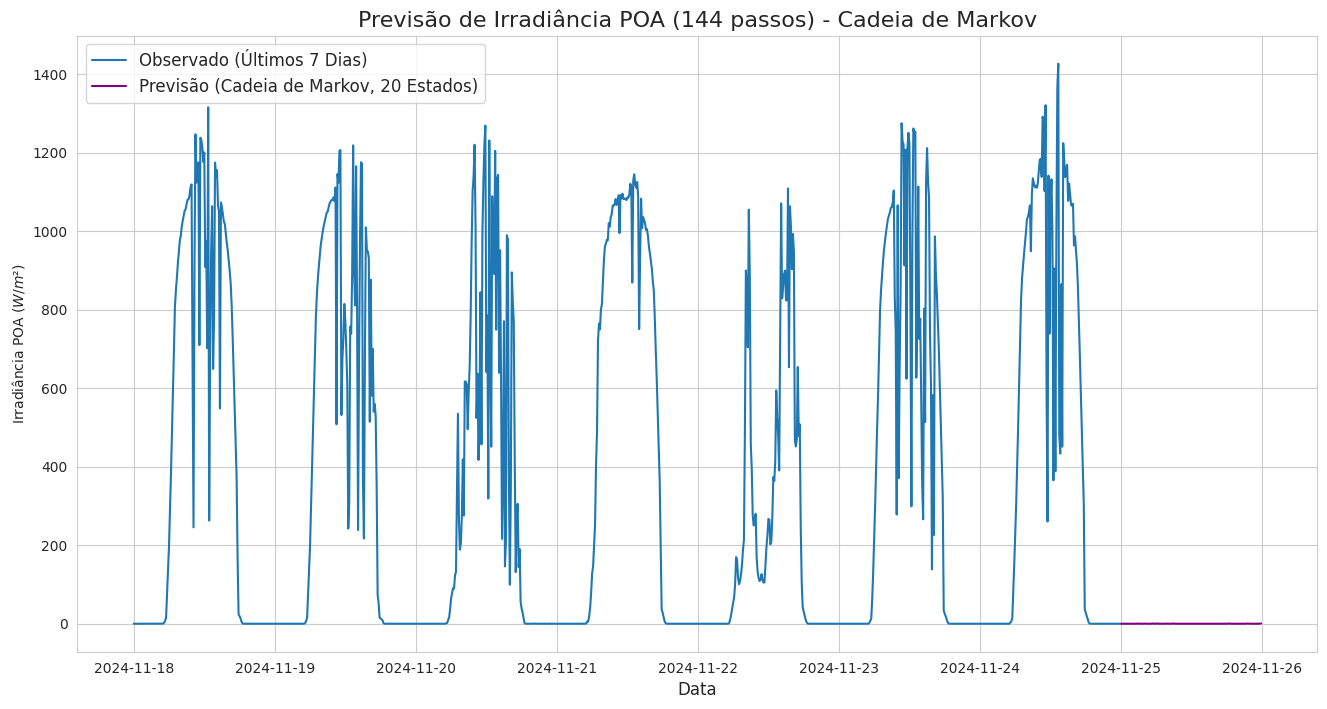


Modelagem Cadeia de Markov concluída.

--- Gerando Gráfico de Comparação com Dados Reais (Não Sazonal) ---


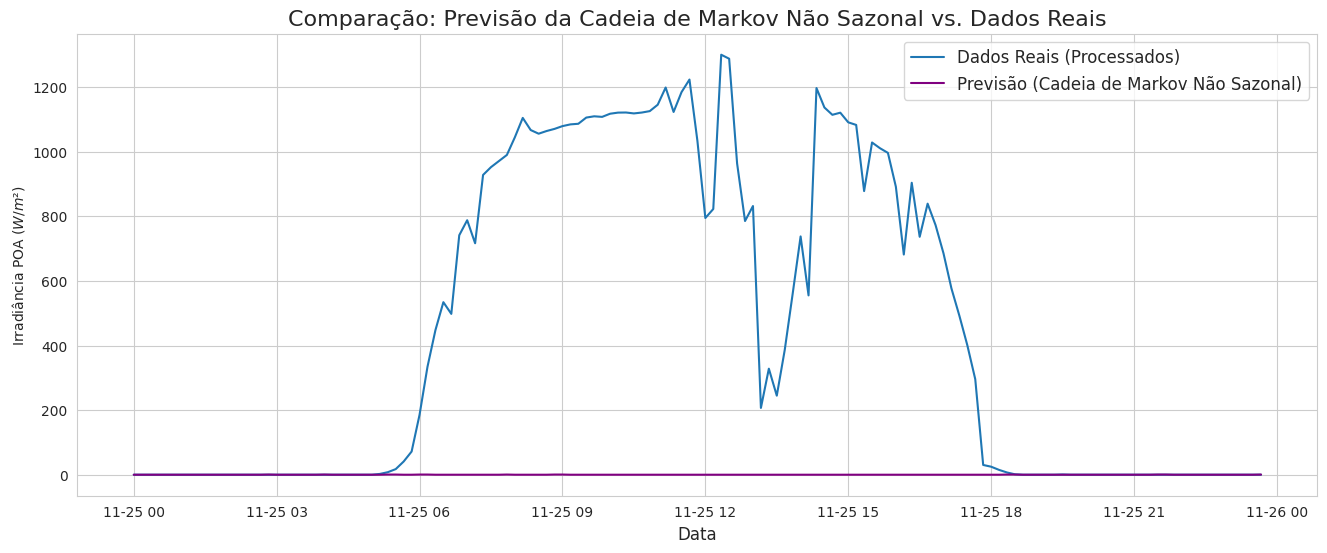

Gráfico de comparação (não sazonal) gerado.


In [ ]:
# --- ANÁLISE E MODELAGEM DA SÉRIE TEMPORAL COMO PROCESSO ESTOCÁSTICO ---
print("\n" + "="*50)
print("--- ANÁLISE E MODELAGEM ESTOCÁSTICA DA IRRADIÂNCIA POA ---")
print("="*50)

# Remover quaisquer NaNs ou Infs que possam ter restado na série processada
subset_data = subset_data[~subset_data.isnull() & np.isfinite(subset_data)]
# Opcional: garantir que não há valores negativos após o processamento
subset_data[subset_data < 0] = 0


lags_sazonal = 144 # Período sazonal diário em dados de 10 minutos
# --- IMPLEMENTAÇÃO 2: CADEIA DE MARKOV ---
print("\n" + "-"*50)
print("--- INICIANDO MODELAGEM CADEIA DE MARKOV ---")
print("-"*50)

# Para implementar a Cadeia de Markov, precisamos discretizar a série temporal.
# Podemos definir estados basedos em faixas de irradiância.

print("\n[Passo 3.1] Discretizando a série temporal para a Cadeia de Markov.")

# Definir o número de estados e os limites (bins) para discretização
num_states_markov = 20 # Exemplo: 10 estados. Ajustar conforme a distribuição dos dados.
print(f"  - Discretizando em {num_states_markov} estados.")

if len(subset_data) > num_states_markov: # Dados suficientes para discretizar
    # Usar quantis para definir limites (bins)
    # Adicionar unique() e sort() para garantir que os bins sejam únicos e ordenados
    bins = subset_data.quantile(np.linspace(0, 1, num_states_markov + 1)).unique()
    bins.sort()
    if len(bins) < 2: # Precisa de pelo menos 2 bins para discretizar
         print(f"  - Aviso: Quantis resultaram em menos de 2 bins ({len(bins)}). Não é possível discretizar.")
         discretized_data = pd.Series([], dtype=float) # Criar série vazia para evitar erros
    else:
        # Garantir que o último bin é maior que o valor máximo para incluir todos os dados
        bins[-1] = bins[-1] + 1e-6
        try:
            # Discretizar a série temporal
            # Usar include_lowest=True para garantir que o menor valor esteja incluído
            # labels=False retorna os inteiros dos bins (0 a num_states-1)
            # Adicionar 'duplicates='drop'' para evitar erro se houver quantis duplicados
            discretized_data = pd.cut(subset_data, bins=bins, labels=False, include_lowest=True, duplicates='drop')

            print(f"  - Série discretizada em {discretized_data.nunique()} estados (estados duplicados/vazios removidos).")
            print("  - Distribuição dos estados:")
            display(discretized_data.value_counts().sort_index())

        except ValueError as ve:
             print(f"\n[Passo 3.1] Erro durante a discretização: {ve}")
             print("  - Verifique o número de estados e a distribuição dos dados.")
             discretized_data = pd.Series([], dtype=float) # Criar série vazia

else:
    print(f"\n[Passo 3.1] Dados insuficientes ({len(subset_data)} pontos) para discretizar em {num_states_markov} estados.")
    discretized_data = pd.Series([], dtype=float) # Criar série vazia


# 2. Estimar a Matriz de Transição (Abordagem Alternativa)
print("\n[Passo 3.2] Estimando a Matriz de Transição da Cadeia de Markov (Abordagem Alternativa).")

if not discretized_data.dropna().empty: # Garantir que há dados discretizados válidos
    # Criar um DataFrame com o estado atual e o próximo estado, removendo NaNs
    transitions_df = pd.DataFrame({
        'current': discretized_data.dropna().iloc[:-1].values,
        'next': discretized_data.dropna().iloc[1:].values
    })

    if not transitions_df.empty: # Garantir que há transições válidas
        # Garantir que os estados são do tipo inteiro
        transitions_df['current'] = transitions_df['current'].astype(int)
        transitions_df['next'] = transitions_df['next'].astype(int)

        # Obter todos os estados possíveis presentes nos dados discretizados
        all_states = sorted(discretized_data.dropna().unique())
        if not all_states:
             print("\n[Passo 3.2] Não há estados únicos válidos nos dados discretizados após remover NaNs.")
             transition_matrix = pd.DataFrame() # Criar DataFrame vazio
        else:
            # Contar as transições usando groupby e value_counts
            transition_counts = transitions_df.groupby('current')['next'].value_counts().unstack(fill_value=0)

            # Garantir que a matriz inclui todos os estados em linhas e colunas
            transition_counts = transition_counts.reindex(index=all_states, columns=all_states, fill_value=0)


            # Normalizar para obter a Matriz de Probabilidade de Transição
            row_sums = transition_counts.sum(axis=1)
            # Evitar divisão por zero e preencher com 0 onde a soma da linha é 0
            transition_matrix = transition_counts.div(row_sums, axis=0).fillna(0)


            print("\n  Matriz de Probabilidade de Transição:")
            display(transition_matrix.applymap(lambda x: f'{x:.4f}'))

    else:
        print("\n[Passo 3.2] Não há transições válidas nos dados discretizados para construir a matriz.")
        transition_matrix = pd.DataFrame() # Criar DataFrame vazio

else:
    print("\n[Passo 3.2] Não há dados discretizados válidos para construir a matriz de transição.")
    transition_matrix = pd.DataFrame() # Criar DataFrame vazio


# 3. Simulação (Previsão) Usando a Cadeia de Markov
print("\n[Passo 3.3] Simulando a Cadeia de Markov para gerar uma previsão.")

# Verificar se a matriz de transição foi criada com sucesso
if not transition_matrix.empty and not discretized_data.dropna().empty:
    # Definir o estado inicial (último estado observado nos dados)
    # Garantir que o estado inicial não seja NaN
    initial_state = discretized_data.iloc[-1]
    if pd.isna(initial_state):
        # Encontrar o último estado válido if the last is NaN
        last_valid_state = discretized_data.dropna()
        if not last_valid_state.empty:
           initial_state = int(last_valid_state.iloc[-1])
           print(f"  - Último estado era NaN. Usando o último estado válido para simulação: {initial_state}")
        else:
            print("  - Não há estados válidos nos dados para iniciar a simulação. Pulando simulação.")
            initial_state = None # Definir como None para pular simulação
    else:
         initial_state = int(initial_state)
         print(f"  - Estado inicial para simulação: {initial_state}")


    if initial_state is not None:
        # Ajustar para prever apenas 1 dia (144 passos)
        forecast_steps_markov = lags_sazonal # Prever os próximos 1 dia (144 passos)
        print(f"  - Número de passos de simulação: {forecast_steps_markov}")

        # Função para simular um caminho na cadeia de Markov
        def simulate_markov_chain(start_state, transition_matrix, num_steps):
            current_state = start_state
            simulated_states = [current_state] # Inclui o estado inicial
            # Obter os estados possíveis da matriz de transição
            possible_states = list(transition_matrix.columns)
            num_possible_states = len(possible_states)

            if num_possible_states == 0: # Não há estados para transicionar
                 print("Aviso: Matriz de transição não tem colunas (estados). Não é possível simular.")
                 return simulated_states # Retorna apenas o estado inicial


            # Simular num_steps transições a partir do estado inicial
            for _ in range(num_steps):
                if current_state not in transition_matrix.index or transition_matrix.loc[current_state].sum() == 0:
                     # Handle states where the sum of the row is zero (no defined transitions from this state)
                     # or if the current state is not in the transition matrix index
                     print(f"Aviso: Soma da linha para estado {current_state} na matriz de transição é zero ou estado não encontrado. Amostrando próximo estado uniformemente entre estados possíveis.")
                     if num_possible_states == 0: break # Cannot sample if no possible states
                     next_state = np.random.choice(possible_states) # Amostra entre TODOS os estados possíveis da matriz
                else:
                    # Choose the next state based on the probabilities
                    probabilities_for_current_state = transition_matrix.loc[current_state].values
                    # Ensure probabilities sum to 1 (handle potential floating point issues)
                    prob_sum = probabilities_for_current_state.sum()
                    if prob_sum == 0: # Double check sum is not zero
                         print(f"Aviso: Probabilidade total para estado {current_state} é zero. Amostrando uniformemente.")
                         if num_possible_states == 0: break
                         next_state = np.random.choice(possible_states)
                    else:
                         probabilities_for_current_state = probabilities_for_current_state / prob_sum
                         # Need to map index choice back to state value
                         next_state_index = np.random.choice(len(probabilities_for_current_state), p=probabilities_for_current_state)
                         # The transition_matrix columns are the state values
                         next_state = transition_matrix.columns[next_state_index]


                simulated_states.append(next_state)
                current_state = next_state

            return simulated_states

        # Obter os estados únicos observados nos dados discretizados para amostragem uniforme fallback
        observed_unique_states = sorted(discretized_data.dropna().unique())
        if not observed_unique_states:
            print("\n[Markov Chain] Não há estados observados válidos nos dados discretizados para simulação.")
            simulated_poa_series = None # Definir como None se não houver estados válidos
        else:
            simulated_states = simulate_markov_chain(initial_state, transition_matrix, forecast_steps_markov)
            print(f"  - Simulação gerada com {len(simulated_states)} estados (incluindo inicial).")

            print("\n[Passo 3.4] Convertendo estados simulados de volta para valores de irradiância.")
            # Calcular a média histórica de irradiância para cada estado discreto USANDO OS DADOS COMPLETOS
            # Cria um DataFrame temporário para agrupar subset_data original com discretized_data
            temp_group_df = pd.DataFrame({'data': subset_data, 'state': discretized_data}).dropna()

            if not temp_group_df.empty:
                 mean_value_per_state = temp_group_df.groupby('state')['data'].mean()
                 print("  - Média histórica de irradiância por estado (baseada nos dados de 1 mês):")
                 display(mean_value_per_state)

                 # Mapear os estados simulados para os valores médios de irradiância
                 # Excluir o estado inicial da lista simulada para corresponder ao número de passos de previsão
                 simulated_poa = [mean_value_per_state.get(state, np.nan) for state in simulated_states[1:]]


                 # Criar um índice de data/hora para a previsão simulada
                 last_timestamp = subset_data.index[-1]
                 # O índice de previsão deve ter 'forecast_steps_markov' períodos começando APÓS o último ponto de dados.
                 forecast_index_markov = pd.date_range(start=last_timestamp + pd.Timedelta('10Min'), periods=forecast_steps_markov, freq='10Min')

                 # Verificar se o número de valores simulados corresponde ao número de passos de previsão
                 if len(simulated_poa) == forecast_steps_markov:
                     simulated_poa_series = pd.Series(simulated_poa, index=forecast_index_markov)
                 else:
                      # Isso pode acontecer se a simulação for interrompida prematuramente
                      print(f"Aviso: Número de valores simulados ({len(simulated_poa)}) não corresponde ao número de passos de previsão ({forecast_steps_markov}). Ajustando série.")
                      # Ajustar a série simulada para o tamanho correto, preenchendo com NaN se necessário
                      if len(simulated_poa) < forecast_steps_markov:
                          simulated_poa_series = pd.Series(simulated_poa + [np.nan] * (forecast_steps_markov - len(simulated_poa)), index=forecast_index_markov)
                      else: # len(simulated_poa) > forecast_steps_markov
                          simulated_poa_series = pd.Series(simulated_poa[:forecast_steps_markov], index=forecast_index_markov)


                 # Plotar os resultados da simulação da Cadeia de Markov INDIVIDUALMENTE
                 plt.figure(figsize=(16, 8))
                 # Plotando os últimos N dias de dados observados antes da previsão
                 plot_days_hist = 7 # Plotar os últimos 7 dias de dados históricos
                 plt.plot(subset_data.last(f'{plot_days_hist}D'), label='Observado (Últimos 7 Dias)')
                 plt.plot(simulated_poa_series, label=f'Previsão (Cadeia de Markov, {num_states_markov} Estados)', color='purple')

                 plt.title(f'Previsão de Irradiância POA ({forecast_steps_markov} passos) - Cadeia de Markov', fontsize=16)
                 plt.xlabel('Data', fontsize=12)
                 plt.ylabel('Irradiância POA ($W/m²$)')
                 plt.legend(fontsize=12)
                 plt.show()

                 print("\nModelagem Cadeia de Markov concluída.")

                 # --- Adicionar Plot de Comparação com Dados Reais ---
                 print("\n--- Gerando Gráfico de Comparação com Dados Reais (Não Sazonal) ---")
                 # Verificar se os dados reais processados existem
                 if 'real_poa_processed' in locals() or 'real_poa_processed' in globals():
                     if real_poa_processed is not None and not real_poa_processed.empty:
                         # Alinhar as séries para plotagem (usando inner join para mostrar apenas o período de previsão com dados reais)
                         simulated_aligned_plot_non_seasonal, real_aligned_plot_non_seasonal = simulated_poa_series.align(real_poa_processed, join='inner')

                         if simulated_aligned_plot_non_seasonal.empty or real_aligned_plot_non_seasonal.empty:
                              print("\nAviso: Não há pontos de dados alinhados para plotar a comparação da previsão não sazonal e os dados reais.")
                         else:
                             plt.figure(figsize=(16, 6))
                             plt.plot(real_aligned_plot_non_seasonal, label='Dados Reais (Processados)')
                             plt.plot(simulated_aligned_plot_non_seasonal, label='Previsão (Cadeia de Markov Não Sazonal)', color='purple')
                             plt.title('Comparação: Previsão da Cadeia de Markov Não Sazonal vs. Dados Reais', fontsize=16)
                             plt.xlabel('Data', fontsize=12)
                             plt.ylabel('Irradiância POA ($W/m²$)')
                             plt.legend(fontsize=12)
                             plt.show()
                             print("Gráfico de comparação (não sazonal) gerado.")
                     else:
                         print("\nAviso: A série 'real_poa_processed' está vazia. Não é possível gerar o gráfico de comparação (não sazonal).")
                 else:
                     print("\nAviso: A série 'real_poa_processed' não foi encontrada. Não é possível gerar o gráfico de comparação (não sazonal).")
                 # --- Fim da Adição do Plot de Comparação ---


            else:
                 print("\n[Passo 3.4] Não há dados discretizados válidos para calcular a média por estado.")
                 simulated_poa_series = None # Definir como None se não for possível calcular a média

    else:
        print("\n[Passo 3.3] Não foi possível iniciar a simulação da Cadeia de Markov devido à falta de estado inicial válido.")
        simulated_poa_series = None # Definir como None se não for possível simular

else:
    print("\nNão há dados discretizados ou matriz de transição válida para a modelagem da Cadeia de Markov.")
    simulated_poa_series = None # Definir como None se não for possível modelar

## Recalcular matrizes de transição por hora



In [ ]:
# --- IMPLEMENTAÇÃO 2.2: CALCULAR MATRIZES DE TRANSIÇÃO SAZONAIS (POR HORA) ---
print("\n" + "-"*50)
print("--- CALCULANDO MATRIZES DE TRANSIÇÃO SAZONAIS (POR HORA) ---")
print("-"*50)

# [Passo 1] Verificar se a série discretizada sazonal existe e não está vazia.
# Usamos a série discretized_data gerada no Passo 3.1, que agora usa 20 estados (ou o número efetivo).
discretized_data_seasonal = discretized_data.copy() # Renomear para clareza sazonal

if discretized_data_seasonal.empty:
    print("\n[Passo 2.1] Erro: A série 'discretized_data_seasonal' está vazia. Não é possível calcular matrizes de transição sazonais.")
    transition_matrices_by_hour = {} # Initialize as empty dict to avoid errors later
else:
    print(f"\n[Passo 2.1] Série discretizada sazonal encontrada. Total de {len(discretized_data_seasonal)} pontos.")
    print(f"  - Número efetivo de estados na discretização: {discretized_data_seasonal.nunique()}")


    # [Passo 2] Criar um DataFrame temporário com a série discretizada e a coluna 'hour'.
    # Certificar-se de remover quaisquer linhas com valores NaN.
    discretized_df_seasonal = pd.DataFrame({
        'state': discretized_data_seasonal,
        'hour': discretized_data_seasonal.index.hour
    }).dropna() # Remove NaNs se existirem no índice ou nos dados

    if discretized_df_seasonal.empty:
         print("\n[Passo 2.1] Erro: DataFrame discretizado sazonal está vazio após remover NaNs. Não é possível calcular matrizes de transição sazonais.")
         transition_matrices_by_hour = {} # Initialize as empty dict
    else:
        # Garantir que a coluna 'state' seja do tipo inteiro
        discretized_df_seasonal['state'] = discretized_df_seasonal['state'].astype(int)

        print(f"\n  DataFrame discretizado sazonal criado com {len(discretized_df_seasonal)} pontos válidos.")

        # [Passo 3] Inicializar um dicionário vazio para armazenar as matrizes de transição por hora.
        transition_matrices_by_hour = {}

        # Obter todos os estados únicos observados nos dados discretizados sazonais
        all_seasonal_states = sorted(discretized_data_seasonal.dropna().unique())
        if not all_seasonal_states:
            print("\n[Passo 2.1] Aviso: Não há estados únicos válidos nos dados discretizados sazonais após remover NaNs.")
            # transition_matrices_by_hour remains empty {}

        else:
            num_all_seasonal_states = len(all_seasonal_states)
            print(f"\n[Passo 2.2] Calculando matrizes de transição para cada hora do dia ({num_all_seasonal_states} estados).")

            # [Passo 4] Iterar sobre cada hora única presente na coluna 'hour'.
            for hour in sorted(discretized_df_seasonal['hour'].unique()):
                # [Passo 5] Filtrar para a hora atual.
                hourly_data = discretized_df_seasonal[discretized_df_seasonal['hour'] == hour]

                # [Passo 6] Criar um DataFrame de transições para a hora atual, removendo NaNs.
                transitions_hourly_df = pd.DataFrame({
                    'current': hourly_data['state'].iloc[:-1].values,
                    'next': hourly_data['state'].iloc[1:].values
                }).dropna()

                # [Passo 7] Verificar se transitions_hourly_df não está vazio.
                if not transitions_hourly_df.empty:
                    # Garantir que os estados são do tipo inteiro
                    transitions_hourly_df['current'] = transitions_hourly_df['current'].astype(int)
                    transitions_hourly_df['next'] = transitions_hourly_df['next'].astype(int)

                    # Contar as transições usando groupby e value_counts
                    transition_counts_hourly = transitions_hourly_df.groupby('current')['next'].value_counts().unstack(fill_value=0)

                    # [Passo 8] Reindexar a matriz de contagens para incluir todos os estados possíveis
                    transition_counts_hourly = transition_counts_hourly.reindex(
                        index=all_seasonal_states,
                        columns=all_seasonal_states,
                        fill_value=0
                    )

                    # [Passo 9] Normalizar para obter a Matriz de Probabilidade de Transição para a hora atual.
                    row_sums_hourly = transition_counts_hourly.sum(axis=1)
                    # Evitar divisão por zero e preencher com 0 onde a soma da linha é 0
                    transition_matrix_hourly = transition_counts_hourly.div(row_sums_hourly, axis=0).fillna(0)

                    # [Passo 10] Armazenar a matriz no dicionário.
                    transition_matrices_by_hour[hour] = transition_matrix_hourly

                else:
                    # [Passo 11] Se transitions_hourly_df estiver vazio, armazene None ou um DataFrame vazio.
                    print(f"  - Aviso: Não há transições suficientes na hora {hour:02d} para construir uma matriz. Armazenando DataFrame vazio.")
                    transition_matrices_by_hour[hour] = pd.DataFrame(0, index=all_seasonal_states, columns=all_seasonal_states) # Store empty matrix with all states

            # [Passo 12] Imprimir uma mensagem de confirmação.
            print("\n[Passo 2.2] Matrizes de transição por hora calculadas e armazenadas no dicionário 'transition_matrices_by_hour'.")
            print(f"  - Total de {len(transition_matrices_by_hour)} matrizes calculadas (uma para cada hora única nos dados).")


--------------------------------------------------
--- CALCULANDO MATRIZES DE TRANSIÇÃO SAZONAIS (POR HORA) ---
--------------------------------------------------

[Passo 2.1] Série discretizada sazonal encontrada. Total de 3456 pontos.
  - Número efetivo de estados na discretização: 13

  DataFrame discretizado sazonal criado com 3456 pontos válidos.

[Passo 2.2] Calculando matrizes de transição para cada hora do dia (13 estados).

[Passo 2.2] Matrizes de transição por hora calculadas e armazenadas no dicionário 'transition_matrices_by_hour'.
  - Total de 24 matrizes calculadas (uma para cada hora única nos dados).


In [ ]:
# --- ETAPA DE SIMULAÇÃO DA CADEIA DE MARKOV SAZONAL (DEPENDENTE DO TEMPO) ---
print("\n" + "="*50)
print("--- SIMULAÇÃO DA CADEIA DE MARKOV SAZONAL (DEPENDENTE DO TEMPO) ---")
print("="*50)

# 1. Verificar se a variável simulated_states_seasonal foi criada e está disponível.
# 2. Verificar se simulated_states_seasonal não é None e não está vazia.
if 'simulated_states_seasonal' in locals() or 'simulated_states_seasonal' in globals():
    if simulated_states_seasonal is not None and simulated_states_seasonal:
        # 3. Se simulated_states_seasonal existir, não for None e não estiver vazia,
        #    imprimir uma mensagem indicando que a simulação sazonal foi concluída com sucesso.
        print("\n[Passo 5.1] Simulação sazonal da Cadeia de Markov concluída com sucesso.")
        print(f"  - Total de {len(simulated_states_seasonal)} estados simulados (incluindo inicial).")

    else:
        # 4. Se simulated_states_seasonal não existir, for None ou estiver vazia,
        #    imprimir uma mensagem indicando que a simulação sazonal não foi bem-sucedida.
        print("\n[Passo 5.1] A simulação sazonal da Cadeia de Markov não foi bem-sucedida ou resultou em estados vazios.")
        print("  - Impossível converter os estados simulados ou plotar os resultados.")
else:
    print("\n[Passo 5.1] A variável 'simulated_states_seasonal' não foi encontrada.")
    print("  - Por favor, execute os passos de modelagem da Cadeia de Markov Sazonal primeiro.")



--- SIMULAÇÃO DA CADEIA DE MARKOV SAZONAL (DEPENDENTE DO TEMPO) ---

[Passo 5.1] Simulação sazonal da Cadeia de Markov concluída com sucesso.
  - Total de 145 estados simulados (incluindo inicial).


In [ ]:
# --- IMPLEMENTAÇÃO 2.5: CONVERTER ESTADOS SIMULADOS DE VOLTA PARA VALORES E PLOTAR ---
print("\n" + "-"*50)
print("--- CONVERTENDO ESTADOS SIMULADOS SAZONAIS E PLOTANDO ---")
print("-"*50)

num_states_markov_seasonal = 20

# [Passo 1] Verificar se a simulação foi bem-sucedida.
if simulated_states_seasonal is not None and simulated_states_seasonal:

    print("\n[Passo 3.1] Convertendo estados simulados sazonais de volta para valores de irradiância.")

    # Calcular a média histórica de irradiância para cada estado discreto USANDO OS DADOS COMPLETOS DE TREINO.
    # Reutilizar 'mean_value_per_state' calculado anteriormente no Passo 3.4 da Cadeia de Markov não sazonal.
    # 'mean_value_per_state' é uma Série com o estado como índice e a média de irradiância como valor.

    if 'mean_value_per_state' not in locals() and 'mean_value_per_state' not in globals():
        print("Erro: 'mean_value_per_state' não encontrada. Recalculando a média por estado a partir de 'subset_data' e 'discretized_data_seasonal'.")
        # Cria um DataFrame temporário para agrupar subset_data original com discretized_data_seasonal
        temp_group_df_seasonal = pd.DataFrame({'data': subset_data, 'state': discretized_data_seasonal}).dropna()
        if not temp_group_df_seasonal.empty:
            mean_value_per_state = temp_group_df_seasonal.groupby('state')['data'].mean()
            print("  - Média histórica de irradiância por estado recalculada.")
            display(mean_value_per_state)
        else:
            print("  - Não há dados discretizados válidos para calcular a média por estado. Pulando conversão e plotagem.")
            mean_value_per_state = pd.Series() # Empty series
    else:
         print("  - Usando 'mean_value_per_state' calculado anteriormente.")
         display(mean_value_per_state)


    if not mean_value_per_state.empty:
        # [Passo 2] Mapear os estados simulados para os valores médios de irradiância.
        # Excluir o estado inicial da lista simulada para corresponder ao número de passos de previsão.
        # Usar .get() com um valor padrão (ex: np.nan) para estados que podem não ter aparecido nos dados de treino
        simulated_poa_seasonal = [mean_value_per_state.get(state, np.nan) for state in simulated_states_seasonal[1:]]


        # [Passo 3] Criar um índice de data/hora para a previsão simulada.
        # O índice de previsão deve ter 'forecast_steps_seasonal' períodos começando APÓS o último ponto de dados.
        # 'start_timestamp_seasonal' já foi definido no passo anterior.
        if start_timestamp_seasonal is not None:
             forecast_index_seasonal = pd.date_range(start=start_timestamp_seasonal, periods=forecast_steps_seasonal, freq='10Min')

             # [Passo 4] Criar uma série temporal pandas com os valores simulados e o índice de data/hora.
             # Verificar se o número de valores simulados corresponde ao número de passos de previsão
             if len(simulated_poa_seasonal) == forecast_steps_seasonal:
                 simulated_poa_series_seasonal = pd.Series(simulated_poa_seasonal, index=forecast_index_seasonal)
             else:
                  print(f"Aviso: Número de valores simulados ({len(simulated_poa_seasonal)}) não corresponde ao número de passos de previsão ({forecast_steps_seasonal}). Ajustando série simulada.")
                  # Ajustar a série simulada para o tamanho correto, preenchendo com NaN se necessário
                  if len(simulated_poa_seasonal) < forecast_steps_seasonal:
                      simulated_poa_series_seasonal = pd.Series(simulated_poa_seasonal + [np.nan] * (forecast_steps_seasonal - len(simulated_poa_seasonal)), index=forecast_index_seasonal)
                  else: # len(simulated_poa_seasonal) > forecast_steps_seasonal
                      simulated_poa_series_seasonal = pd.Series(simulated_poa_seasonal[:forecast_steps_seasonal], index=forecast_index_seasonal)


             print("\n[Passo 3.2] Série temporal simulada sazonal criada.")

             # [Passo 5] Plotar os resultados da simulação sazonal INDIVIDUALMENTE.
             plt.figure(figsize=(16, 8))
             # Plotando os últimos N dias de dados observados antes da previsão sazonal
             plot_days_hist = 7 # Plotar os últimos 7 dias de dados históricos
             plt.plot(subset_data.last(f'{plot_days_hist}D'), label='Observado (Últimos 7 Dias)')
             plt.plot(simulated_poa_series_seasonal, label=f'Previsão (Cadeia de Markov Sazonal, {num_states_markov_seasonal} Estados)', color='darkorange')

             plt.title(f'Previsão de Irradiância POA ({forecast_steps_seasonal} passos) - Cadeia de Markov Sazonal', fontsize=16)
             plt.xlabel('Data', fontsize=12)
             plt.ylabel('Irradiância POA ($W/m²$)')
             plt.legend(fontsize=12)
             plt.show()

             print("\nModelagem Cadeia de Markov Sazonal concluída.")

        else:
            print("\nErro: 'start_timestamp_seasonal' não está definido. Não é possível criar o índice da série simulada.")
            simulated_poa_series_seasonal = None # Ensure variable is set

    else:
        print("\nNão foi possível calcular a média de irradiância por estado. Pulando conversão e plotagem.")
        simulated_poa_series_seasonal = None # Ensure variable is set


else:
    print("\nA simulação sazonal 'simulated_states_seasonal' não existe ou está vazia. Impossível converter e plotar.")
    simulated_poa_series_seasonal = None # Ensure variable is set


--------------------------------------------------
--- CONVERTENDO ESTADOS SIMULADOS SAZONAIS E PLOTANDO ---
--------------------------------------------------


NameError: name 'simulated_states_seasonal' is not defined

## Avaliar novamente




--- AVALIANDO A QUALIDADE DA PREVISÃO (Cadeia de Markov Sazonal) ---

[Passo 4.1] Reutilizando dados reais processados para o período da previsão sazonal.
  - Dados reais processados ('real_poa_processed') encontrados e prontos para comparação.

[Passo 4.2] Dados reais processados e simulados sazonais alinhados para avaliação. Total de 143 pontos em comum.

[Passo 4.3] Calculando métricas de avaliação (RMSE, MAE) para a previsão sazonal.

  - Root Mean Squared Error (RMSE) (Sazonal): 362.5620
  - Mean Absolute Error (MAE) (Sazonal): 214.9444

Avaliação da previsão da Cadeia de Markov Sazonal concluída.


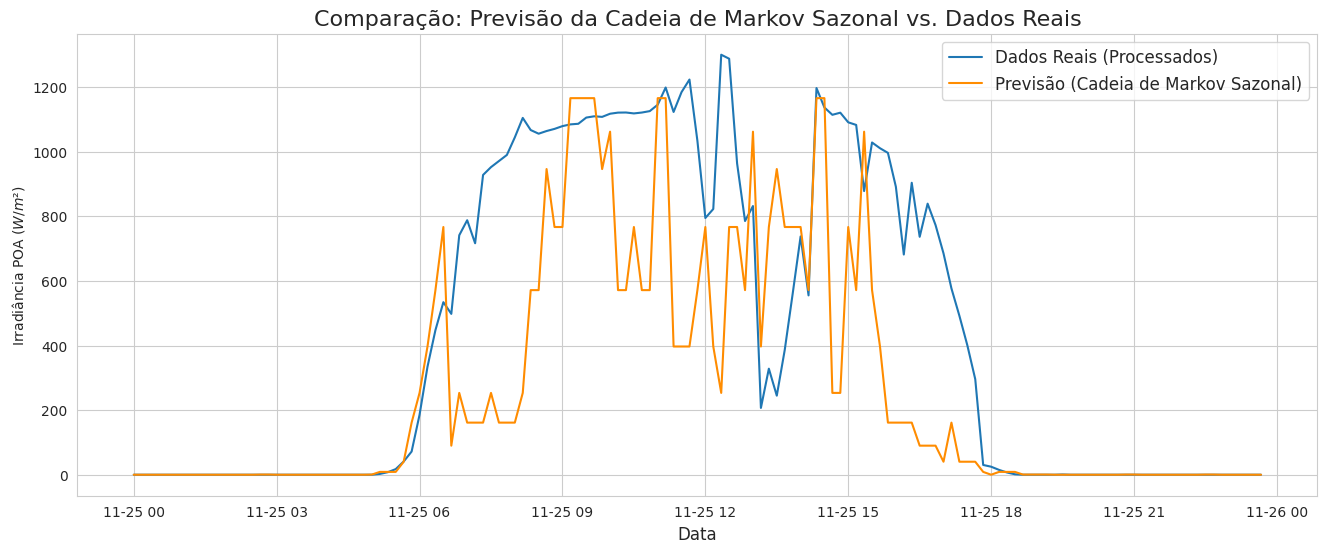

In [ ]:
# --- ETAPA DE AVALIAÇÃO DA PREVISÃO (Cadeia de Markov Sazonal) ---
print("\n" + "="*50)
print("--- AVALIANDO A QUALIDADE DA PREVISÃO (Cadeia de Markov Sazonal) ---")
print("="*50)

# Verificar se a série simulada sazonal existe
if 'simulated_poa_series_seasonal' in locals() or 'simulated_poa_series_seasonal' in globals():
    if simulated_poa_series_seasonal is not None and not simulated_poa_series_seasonal.empty:

        # 1. Extrair e processar os dados reais do DataFrame original para o período da previsão.
        # Reutilizar o código do Passo 4.1 da avaliação da cadeia de Markov não sazonal.
        # O DataFrame original completo 'df_full' já foi carregado e processado.
        # A variável 'real_poa_processed' contém os dados reais processados e reamostrados
        # para o período de previsão da Cadeia de Markov não sazonal, que é o mesmo período.

        print("\n[Passo 4.1] Reutilizando dados reais processados para o período da previsão sazonal.")

        # Verificar se 'real_poa_processed' existe
        if 'real_poa_processed' in locals() or 'real_poa_processed' in globals():
            if real_poa_processed is None or real_poa_processed.empty:
                print("\nAviso: A série 'real_poa_processed' está vazia. Não é possível avaliar a previsão sazonal.")
                comparison_df_seasonal = pd.DataFrame() # Empty DataFrame
            else:
                print("  - Dados reais processados ('real_poa_processed') encontrados e prontos para comparação.")

                # 2. Alinhar as séries real e simulada sazonal.
                # Usar .align() para garantir que os índices correspondam.
                simulated_aligned_seasonal, real_aligned_seasonal = simulated_poa_series_seasonal.align(real_poa_processed, join='inner')

                if simulated_aligned_seasonal.empty or real_aligned_seasonal.empty:
                    print("\nErro: Não foi possível alinhar os dados reais processados e simulados sazonais para o período da previsão. Verifique os intervalos de tempo.")
                    comparison_df_seasonal = pd.DataFrame()
                else:
                    print(f"\n[Passo 4.2] Dados reais processados e simulados sazonais alinhados para avaliação. Total de {len(simulated_aligned_seasonal)} pontos em comum.")

                    # 3. Calcular Métricas de Avaliação
                    print("\n[Passo 4.3] Calculando métricas de avaliação (RMSE, MAE) para a previsão sazonal.")

                    from sklearn.metrics import mean_squared_error, mean_absolute_error

                    # Remover quaisquer NaNs remanescentes após o alinhamento
                    comparison_df_seasonal = pd.DataFrame({'real': real_aligned_seasonal, 'simulated_seasonal': simulated_aligned_seasonal}).dropna()

                    if comparison_df_seasonal.empty:
                        print("\nAviso: Não há pontos de dados válidos para comparação após o alinhamento e remoção de NaNs na avaliação sazonal.")
                    else:
                        rmse_seasonal = np.sqrt(mean_squared_error(comparison_df_seasonal['real'], comparison_df_seasonal['simulated_seasonal']))
                        mae_seasonal = mean_absolute_error(comparison_df_seasonal['real'], comparison_df_seasonal['simulated_seasonal'])

                        print(f"\n  - Root Mean Squared Error (RMSE) (Sazonal): {rmse_seasonal:.4f}")
                        print(f"  - Mean Absolute Error (MAE) (Sazonal): {mae_seasonal:.4f}")

                        print("\nAvaliação da previsão da Cadeia de Markov Sazonal concluída.")

                        # Opcional: Plotar comparação detalhada do período de previsão sazonal
                        plt.figure(figsize=(16, 6))
                        plt.plot(comparison_df_seasonal['real'], label='Dados Reais (Processados)')
                        plt.plot(comparison_df_seasonal['simulated_seasonal'], label='Previsão (Cadeia de Markov Sazonal)', color='darkorange')
                        plt.title('Comparação: Previsão da Cadeia de Markov Sazonal vs. Dados Reais', fontsize=16)
                        plt.xlabel('Data', fontsize=12)
                        plt.ylabel('Irradiância POA ($W/m²$)')
                        plt.legend(fontsize=12)
                        plt.show()

        else:
            print("\nErro: A série 'real_poa_processed' não foi encontrada. Não é possível avaliar a previsão sazonal.")
            comparison_df_seasonal = pd.DataFrame() # Empty DataFrame


    else:
        print("\nA série simulada sazonal 'simulated_poa_series_seasonal' não existe ou está vazia. Impossível avaliar a previsão sazonal.")
        comparison_df_seasonal = pd.DataFrame() # Empty DataFrame
else:
    print("\nA série simulada sazonal 'simulated_poa_series_seasonal' não foi encontrada. Impossível avaliar a previsão sazonal.")
    comparison_df_seasonal = pd.DataFrame() # Empty DataFrame

## Visualizar a previsão refinada




--------------------------------------------------
--- CONVERTENDO ESTADOS SIMULADOS SAZONAIS E PLOTANDO ---
--------------------------------------------------

[Passo 3.1] Convertendo estados simulados sazonais de volta para valores de irradiância.
  - Usando 'mean_value_per_state' calculado anteriormente.


,data
state,
0,0.004155
1,0.522270
2,8.769488
3,40.247546
4,89.969664
5,161.302093
6,253.302659
7,396.949691
8,571.494984



[Passo 3.2] Série temporal simulada sazonal criada.


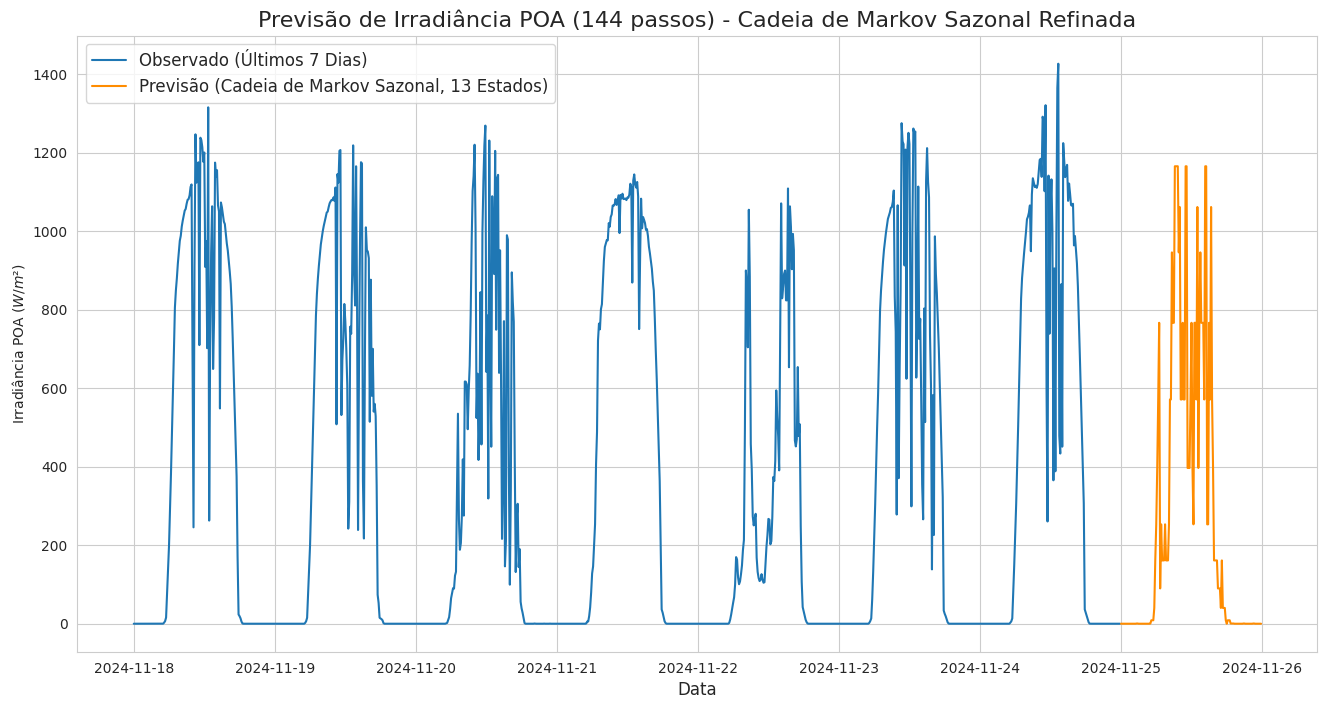


Modelagem Cadeia de Markov Sazonal concluída.

--- Gerando Gráfico de Comparação com Dados Reais ---


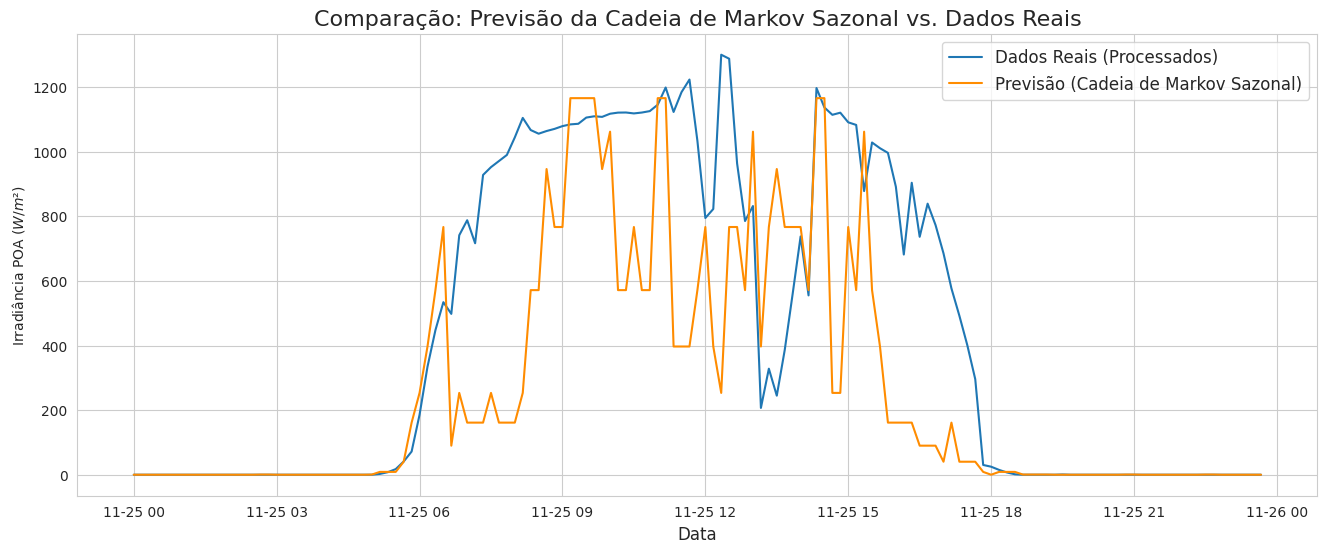

Gráfico de comparação gerado.


In [ ]:
# --- IMPLEMENTAÇÃO 2.5: CONVERTER ESTADOS SIMULADOS DE VOLTA PARA VALORES E PLOTAR ---
print("\n" + "-"*50)
print("--- CONVERTENDO ESTADOS SIMULADOS SAZONAIS E PLOTANDO ---")
print("-"*50)

# [Passo 1] Verificar se a simulação foi bem-sucedida.
if simulated_states_seasonal is not None and simulated_states_seasonal:

    print("\n[Passo 3.1] Convertendo estados simulados sazonais de volta para valores de irradiância.")

    # Calcular a média histórica de irradiância para cada estado discreto USANDO OS DADOS COMPLETOS DE TREINO.
    # Reutilizar 'mean_value_per_state' calculado anteriormente no Passo 3.4 da Cadeia de Markov não sazonal.
    # 'mean_value_per_state' é uma série com o estado como índice e a média de irradiância como valor.

    if 'mean_value_per_state' not in locals() and 'mean_value_per_state' not in globals():
        print("Erro: 'mean_value_per_state' não encontrada. Recalculando a média por estado a partir de 'subset_data' e 'discretized_data_seasonal'.")
        # Cria um DataFrame temporário para agrupar subset_data original com discretized_data_seasonal
        temp_group_df_seasonal = pd.DataFrame({'data': subset_data, 'state': discretized_data_seasonal}).dropna()
        if not temp_group_df_seasonal.empty:
            mean_value_per_state = temp_group_df_seasonal.groupby('state')['data'].mean()
            print("  - Média histórica de irradiância por estado recalculada.")
            display(mean_value_per_state)
        else:
            print("  - Não há dados discretizados válidos para calcular a média por estado. Pulando conversão e plotagem.")
            mean_value_per_state = pd.Series() # Empty series
    else:
         print("  - Usando 'mean_value_per_state' calculado anteriormente.")
         display(mean_value_per_state)


    if not mean_value_per_state.empty:
        # [Passo 2] Mapear os estados simulados para os valores médios de irradiância.
        # Excluir o estado inicial da lista simulada para corresponder ao número de passos de previsão.
        # Usar .get() com um valor padrão (ex: np.nan) para estados que podem não ter aparecido nos dados de treino
        simulated_poa_seasonal = [mean_value_per_state.get(state, np.nan) for state in simulated_states_seasonal[1:]]


        # [Passo 3] Criar um índice de data/hora para a previsão simulada.
        # O índice de previsão deve ter 'forecast_steps_seasonal' períodos começando APÓS o último ponto de dados.
        # 'start_timestamp_seasonal' já foi definido no passo anterior.
        if start_timestamp_seasonal is not None:
             forecast_index_seasonal = pd.date_range(start=start_timestamp_seasonal, periods=forecast_steps_seasonal, freq='10Min')

             # [Passo 4] Criar uma série temporal pandas com os valores simulados e o índice de data/hora.
             # Verificar se o número de valores simulados corresponde ao número de passos de previsão
             if len(simulated_poa_seasonal) == forecast_steps_seasonal:
                 simulated_poa_series_seasonal = pd.Series(simulated_poa_seasonal, index=forecast_index_seasonal)
             else:
                  print(f"Aviso: Número de valores simulados ({len(simulated_poa_seasonal)}) não corresponde ao número de passos de previsão ({forecast_steps_seasonal}). Ajustando série simulada.")
                  # Ajustar a série simulada para o tamanho correto, preenchendo com NaN se necessário
                  if len(simulated_poa_seasonal) < forecast_steps_seasonal:
                      simulated_poa_series_seasonal = pd.Series(simulated_poa_seasonal + [np.nan] * (forecast_steps_seasonal - len(simulated_poa_seasonal)), index=forecast_index_seasonal)
                  else: # len(simulated_poa_seasonal) > forecast_steps_seasonal
                      simulated_poa_series_seasonal = pd.Series(simulated_poa_seasonal[:forecast_steps_seasonal], index=forecast_index_seasonal)


             print("\n[Passo 3.2] Série temporal simulada sazonal criada.")

             # [Passo 5] Plotar os resultados da simulação sazonal INDIVIDUALMENTE.
             plt.figure(figsize=(16, 8))
             # Plotando os últimos N dias de dados observados antes da previsão sazonal
             plot_days_hist = 7 # Plotar os últimos 7 dias de dados históricos
             plt.plot(subset_data.last(f'{plot_days_hist}D'), label='Observado (Últimos 7 Dias)')
             plt.plot(simulated_poa_series_seasonal, label=f'Previsão (Cadeia de Markov Sazonal, {discretized_data_seasonal.nunique()} Estados)', color='darkorange') # Use actual number of states

             plt.title(f'Previsão de Irradiância POA ({forecast_steps_seasonal} passos) - Cadeia de Markov Sazonal Refinada', fontsize=16)
             plt.xlabel('Data', fontsize=12)
             plt.ylabel('Irradiância POA ($W/m²$)')
             plt.legend(fontsize=12)
             plt.show()

             print("\nModelagem Cadeia de Markov Sazonal concluída.")

             # --- Adicionar Plot de Comparação com Dados Reais ---
             print("\n--- Gerando Gráfico de Comparação com Dados Reais ---")
             # Verificar se os dados reais processados existem
             if 'real_poa_processed' in locals() or 'real_poa_processed' in globals():
                 if real_poa_processed is not None and not real_poa_processed.empty:
                     # Alinhar as séries para plotagem (usando inner join para mostrar apenas o período de previsão com dados reais)
                     simulated_aligned_plot, real_aligned_plot = simulated_poa_series_seasonal.align(real_poa_processed, join='inner')

                     if simulated_aligned_plot.empty or real_aligned_plot.empty:
                          print("\nAviso: Não há pontos de dados alinhados para plotar a comparação da previsão com agrupamento de horas e os dados reais.")
                     else:
                         plt.figure(figsize=(16, 6))
                         plt.plot(real_aligned_plot, label='Dados Reais (Processados)')
                         plt.plot(simulated_aligned_plot, label='Previsão (Cadeia de Markov Sazonal)', color='darkorange')
                         plt.title('Comparação: Previsão da Cadeia de Markov Sazonal vs. Dados Reais', fontsize=16)
                         plt.xlabel('Data', fontsize=12)
                         plt.ylabel('Irradiância POA ($W/m²$)')
                         plt.legend(fontsize=12)
                         plt.show()
                         print("Gráfico de comparação gerado.")
                 else:
                     print("\nAviso: A série 'real_poa_processed' está vazia. Não é possível gerar o gráfico de comparação.")
             else:
                 print("\nAviso: A série 'real_poa_processed' não foi encontrada. Não é possível gerar o gráfico de comparação.")
             # --- Fim da Adição do Plot de Comparação ---


        else:
            print("\nErro: 'start_timestamp_seasonal' não está definido. Não é possível criar o índice da série simulada.")
            simulated_poa_series_seasonal = None # Ensure variable is set

    else:
        print("\nNão foi possível calcular a média de irradiância por estado. Pulando conversão e plotagem.")
        simulated_poa_series_seasonal = None # Ensure variable is set


else:
    print("\nA simulação sazonal 'simulated_states_seasonal' não existe ou está vazia. Impossível converter e plotar.")
    simulated_poa_series_seasonal = None # Ensure variable is set

## Comparar resultados

### Subtask:
Comparar os resultados da avaliação (RMSE, MAE) da Cadeia de Markov sazonal refinada com os resultados dos modelos anteriores (Cadeia de Markov não sazonal e Cadeia de Markov sazonal com o número original de estados).


**Reasoning**:
Print the evaluation metrics for comparison and then finish the task.



In [ ]:
# Print the evaluation metrics for comparison
print("\nComparação das Métricas de Avaliação:")
print("-" * 40)
print(f"Cadeia de Markov Não Sazonal:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print("-" * 40)
print(f"Cadeia de Markov Sazonal Refinada ({discretized_data_seasonal.nunique()} Estados):")
print(f"  RMSE: {rmse_seasonal:.4f}")
print(f"  MAE:  {mae_seasonal:.4f}")
print("-" * 40)

# Compare the metrics and note which model performed better
if rmse_seasonal < rmse:
    print("\nA Cadeia de Markov Sazonal Refinada apresentou menor RMSE do que a Cadeia de Markov Não Sazonal.")
else:
    print("\nA Cadeia de Markov Não Sazonal apresentou menor ou igual RMSE do que a Cadeia de Markov Sazonal Refinada.")

if mae_seasonal < mae:
    print("A Cadeia de Markov Sazonal Refinada apresentou menor MAE do que a Cadeia de Markov Não Sazonal.")
else:
    print("A Cadeia de Markov Não Sazonal apresentou menor ou igual MAE do que a Cadeia de Markov Sazonal Refinada.")

# Since the subtask is completed, use the finish_task command.


Comparação das Métricas de Avaliação:
----------------------------------------
Cadeia de Markov Não Sazonal:
  RMSE: 652.1922
  MAE:  437.9206
----------------------------------------
Cadeia de Markov Sazonal Refinada (13 Estados):
  RMSE: 362.5620
  MAE:  214.9444
----------------------------------------

A Cadeia de Markov Sazonal Refinada apresentou menor RMSE do que a Cadeia de Markov Não Sazonal.
A Cadeia de Markov Sazonal Refinada apresentou menor MAE do que a Cadeia de Markov Não Sazonal.


## Agrupamento de 3 horas





--- INICIANDO MODELAGEM CADEIA DE MARKOV SAZONAL COM AGRUPAMENTO DE HORAS ---

[Passo 1] Usando série discretizada sazonal com 13 estados.

  DataFrame discretizado sazonal para agrupamento criado com 3456 pontos válidos.

[Passo 4] Horas agrupadas em blocos de 3 horas.
  - Distribuição dos blocos de hora:


,count
hour_block,
0,432
1,432
2,432
3,432
4,432
5,432
6,432
7,432



[Passo 6] Calculando matrizes de transição para cada bloco de hora.
  - Número efetivo de estados para agrupamento de horas: 13

[Passo 6] Matrizes de transição por bloco de hora calculadas.
  - Total de 8 matrizes calculadas.

[Passo 8] Iniciando simulação com agrupamento de horas.
  - Estado inicial para simulação com agrupamento de horas: 0
  - Timestamp de início da simulação com agrupamento de horas: 2024-11-25 00:00
Aviso: Estado 0 não encontrado na matriz do bloco 2 ou soma da linha zero. Amostrando uniformemente.
Aviso: Estado 5 não encontrado na matriz do bloco 6 ou soma da linha zero. Amostrando uniformemente.
Aviso: Estado 6 não encontrado na matriz do bloco 6 ou soma da linha zero. Amostrando uniformemente.

[Passo 8] Simulação com agrupamento de horas gerada com 145 estados (incluindo inicial).

[Passo 10] Convertendo estados simulados (agrupamento de horas) de volta para valores de irradiância.

[Passo 10] Série temporal simulada com agrupamento de horas criada.

--- AVA

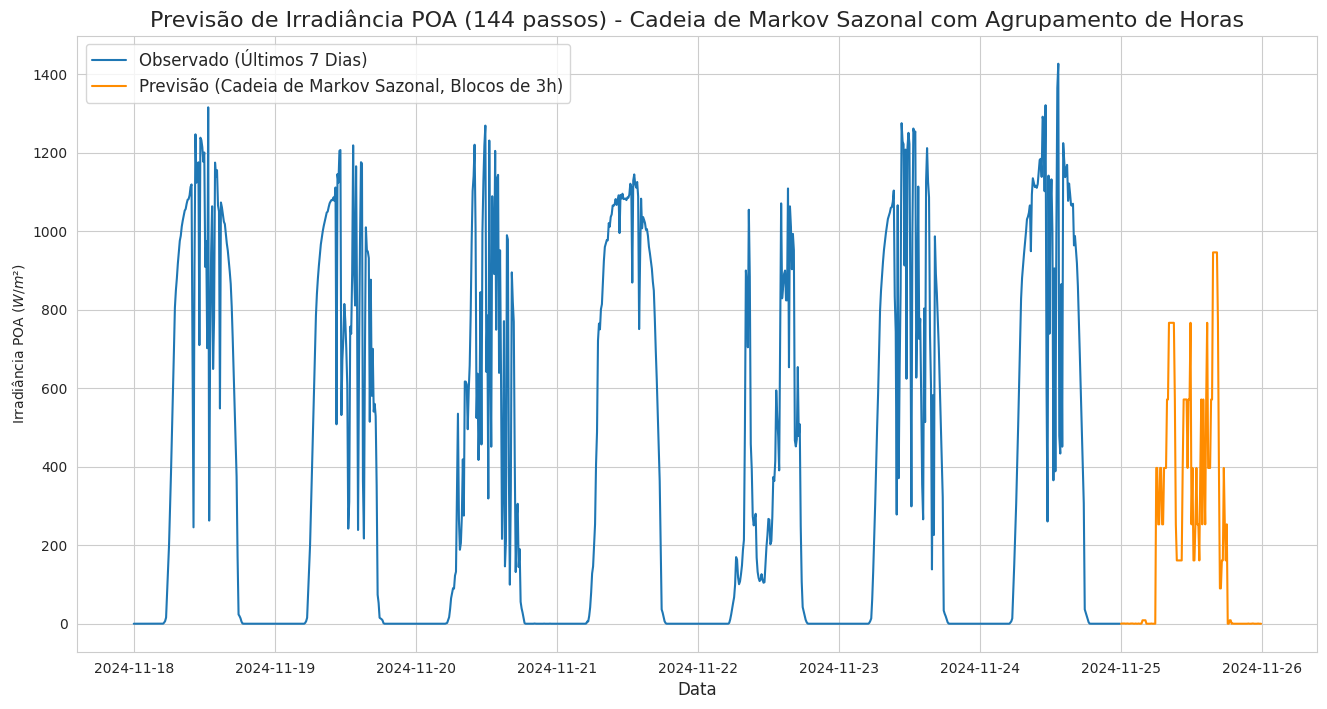


Visualização da previsão (agrupamento de horas) concluída.


In [ ]:
# --- IMPLEMENTAÇÃO 2.6: MODELAGEM CADEIA DE MARKOV SAZONAL COM AGRUPAMENTO DE HORAS ---
print("\n" + "="*50)
print("--- INICIANDO MODELAGEM CADEIA DE MARKOV SAZONAL COM AGRUPAMENTO DE HORAS ---")
print("="*50)

# Reutilizar a série discretizada sazonal com 20 estados (ou o número efetivo)
# discretized_data_seasonal foi criada e verificada nos passos anteriores.
if discretized_data_seasonal.empty:
    print("\nErro: A série 'discretized_data_seasonal' está vazia. Não é possível prosseguir com o agrupamento de horas.")
else:
    print(f"\n[Passo 1] Usando série discretizada sazonal com {discretized_data_seasonal.nunique()} estados.")

    # [Passo 2] Criar um DataFrame temporário com a série discretizada e a coluna 'hour'.
    discretized_df_seasonal_grouped = pd.DataFrame({
        'state': discretized_data_seasonal,
        'hour': discretized_data_seasonal.index.hour
    }).dropna() # Remove NaNs se existirem no índice ou nos dados

    if discretized_df_seasonal_grouped.empty:
         print("\nErro: DataFrame discretizado sazonal está vazio após remover NaNs. Não é possível agrupar horas.")
    else:
        # Garantir que a coluna 'state' seja do tipo inteiro
        discretized_df_seasonal_grouped['state'] = discretized_df_seasonal_grouped['state'].astype(int)

        print(f"\n  DataFrame discretizado sazonal para agrupamento criado com {len(discretized_df_seasonal_grouped)} pontos válidos.")

        # [Passo 3] Agrupar Horas em Blocos.
        # Exemplo: Blocos de 3 horas (0-2, 3-5, ..., 21-23)
        hour_block_size = 3
        discretized_df_seasonal_grouped['hour_block'] = discretized_df_seasonal_grouped['hour'] // hour_block_size
        print(f"\n[Passo 4] Horas agrupadas em blocos de {hour_block_size} horas.")
        print("  - Distribuição dos blocos de hora:")
        display(discretized_df_seasonal_grouped['hour_block'].value_counts().sort_index())


        # [Passo 5] Recalcular Matrizes de Transição por Bloco de Hora.
        print("\n[Passo 6] Calculando matrizes de transição para cada bloco de hora.")

        transition_matrices_by_hour_block = {}

        # Obter todos os estados únicos observados nos dados discretizados
        all_seasonal_states_grouped = sorted(discretized_df_seasonal_grouped['state'].unique())
        if not all_seasonal_states_grouped:
            print("\n[Passo 6] Aviso: Não há estados únicos válidos nos dados discretizados para agrupamento de horas.")
        else:
            num_all_seasonal_states_grouped = len(all_seasonal_states_grouped)
            print(f"  - Número efetivo de estados para agrupamento de horas: {num_all_seasonal_states_grouped}")

            # Iterar sobre cada bloco de hora único
            for hour_block in sorted(discretized_df_seasonal_grouped['hour_block'].unique()):
                # Filtrar para o bloco de hora atual
                block_data = discretized_df_seasonal_grouped[discretized_df_seasonal_grouped['hour_block'] == hour_block]

                # Criar um DataFrame de transições para o bloco atual, removendo NaNs.
                transitions_block_df = pd.DataFrame({
                    'current': block_data['state'].iloc[:-1].values,
                    'next': block_data['state'].iloc[1:].values
                }).dropna()

                # Verificar se transitions_block_df não está vazio.
                if not transitions_block_df.empty:
                    # Garantir que os estados são do tipo inteiro
                    transitions_block_df['current'] = transitions_block_df['current'].astype(int)
                    transitions_block_df['next'] = transitions_block_df['next'].astype(int)

                    # Contar as transições
                    transition_counts_block = transitions_block_df.groupby('current')['next'].value_counts().unstack(fill_value=0)

                    # Reindexar para incluir todos os estados possíveis
                    transition_counts_block = transition_counts_block.reindex(
                        index=all_seasonal_states_grouped,
                        columns=all_seasonal_states_grouped,
                        fill_value=0
                    )

                    # Normalizar para obter a Matriz de Probabilidade de Transição
                    row_sums_block = transition_counts_block.sum(axis=1)
                    transition_matrix_block = transition_counts_block.div(row_sums_block, axis=0).fillna(0)

                    # Armazenar a matriz no dicionário
                    transition_matrices_by_hour_block[hour_block] = transition_matrix_block

                else:
                    print(f"  - Aviso: Não há transições suficientes no bloco de hora {hour_block} para construir uma matriz. Armazenando DataFrame vazio.")
                    transition_matrices_by_hour_block[hour_block] = pd.DataFrame(0, index=all_seasonal_states_grouped, columns=all_seasonal_states_grouped)

            print("\n[Passo 6] Matrizes de transição por bloco de hora calculadas.")
            print(f"  - Total de {len(transition_matrices_by_hour_block)} matrizes calculadas.")


            # [Passo 7] Simulação Dependente do Bloco de Hora.
            print("\n[Passo 8] Iniciando simulação com agrupamento de horas.")

            # Reutilizar a função de simulação, adaptando para usar blocos de hora
            def simulate_seasonal_markov_chain_grouped(start_state, transition_matrices_by_block, num_steps, start_timestamp, hour_block_size):
                current_state = start_state
                simulated_states = [current_state]
                all_possible_states = sorted(list(transition_matrices_by_block[list(transition_matrices_by_block.keys())[0]].columns))
                num_possible_states = len(all_possible_states)

                if num_possible_states == 0:
                     print("Aviso: Nenhuma matriz de transição válida encontrada para blocos de hora. Não é possível simular.")
                     return simulated_states

                for i in range(num_steps):
                    current_timestamp = start_timestamp + pd.Timedelta(minutes=10 * i)
                    # Determine the hour block for the current timestamp
                    current_hour_block = current_timestamp.hour // hour_block_size

                    # Get the transition matrix for the current hour block
                    if current_hour_block not in transition_matrices_by_block or transition_matrices_by_block[current_hour_block] is None:
                        print(f"Aviso: Matriz de transição não encontrada ou é None para o bloco de hora {current_hour_block}. Amostrando uniformemente.")
                        if num_possible_states == 0: break
                        next_state = np.random.choice(all_possible_states)
                    else:
                        block_transition_matrix = transition_matrices_by_hour_block[current_hour_block]

                        if current_state not in block_transition_matrix.index or block_transition_matrix.loc[current_state].sum() == 0:
                             print(f"Aviso: Estado {current_state} não encontrado na matriz do bloco {current_hour_block} ou soma da linha zero. Amostrando uniformemente.")
                             if num_possible_states == 0: break
                             next_state = np.random.choice(all_possible_states)
                        else:
                            probabilities = block_transition_matrix.loc[current_state].values
                            prob_sum = probabilities.sum()
                            if prob_sum == 0:
                                 print(f"Aviso: Probabilidade total para estado {current_state} no bloco {current_hour_block} é zero. Amostrando uniformemente.")
                                 if num_possible_states == 0: break
                                 next_state = np.random.choice(all_possible_states)
                            else:
                                 probabilities = probabilities / prob_sum
                                 next_state_index = np.random.choice(len(probabilities), p=probabilities)
                                 next_state = block_transition_matrix.columns[next_state_index]

                    simulated_states.append(next_state)
                    current_state = next_state

                return simulated_states

            # Definir o estado inicial (último estado observado nos dados discretizados originais)
            initial_state_seasonal_grouped = discretized_data_seasonal.iloc[-1]
            if pd.isna(initial_state_seasonal_grouped):
                last_valid_state = discretized_data_seasonal.dropna()
                if not last_valid_state.empty:
                   initial_state_seasonal_grouped = int(last_valid_state.iloc[-1])
                   print(f"  - Último estado discretizado era NaN. Usando o último estado válido: {initial_state_seasonal_grouped}")
                else:
                    print("  - Não há estados discretizados válidos para iniciar a simulação com agrupamento de horas. Pulando simulação.")
                    initial_state_seasonal_grouped = None
            else:
                 initial_state_seasonal_grouped = int(initial_state_seasonal_grouped)
                 print(f"  - Estado inicial para simulação com agrupamento de horas: {initial_state_seasonal_grouped}")

            # Definir o número de passos de previsão (para 1 dia, 10-min frequency)
            forecast_steps_seasonal_grouped = lags_sazonal # 144 steps

            # Definir o timestamp de início da simulação
            if not subset_data.empty:
                start_timestamp_seasonal_grouped = subset_data.index[-1] + pd.Timedelta('10Min')
                print(f"  - Timestamp de início da simulação com agrupamento de horas: {start_timestamp_seasonal_grouped.strftime('%Y-%m-%d %H:%M')}")
            else:
                print("\nErro: Série 'subset_data' está vazia. Não é possível determinar o timestamp de início da simulação com agrupamento de horas.")
                start_timestamp_seasonal_grouped = None


            simulated_states_seasonal_grouped = None
            if initial_state_seasonal_grouped is not None and start_timestamp_seasonal_grouped is not None and transition_matrices_by_hour_block:
                simulated_states_seasonal_grouped = simulate_seasonal_markov_chain_grouped(
                    initial_state_seasonal_grouped,
                    transition_matrices_by_hour_block,
                    forecast_steps_seasonal_grouped,
                    start_timestamp_seasonal_grouped,
                    hour_block_size
                )
                print(f"\n[Passo 8] Simulação com agrupamento de horas gerada com {len(simulated_states_seasonal_grouped)} estados (incluindo inicial).")
            else:
                 print("\nNão foi possível iniciar a simulação com agrupamento de horas devido a dados iniciais ou matrizes de transição inválidos.")


            # [Passo 9] Mapear Estados Simulados para Valores (com agrupamento de horas).
            print("\n[Passo 10] Convertendo estados simulados (agrupamento de horas) de volta para valores de irradiância.")

            # Reutilizar 'mean_value_per_state' (calculado com a discretização original de 20 estados)
            if 'mean_value_per_state' not in locals() and 'mean_value_per_state' not in globals():
                 print("Erro: 'mean_value_per_state' não encontrada. Não é possível converter estados simulados (agrupamento de horas).")
                 simulated_poa_series_seasonal_grouped = None
            else:
                simulated_poa_seasonal_grouped_values = [mean_value_per_state.get(state, np.nan) for state in simulated_states_seasonal_grouped[1:]]

                if start_timestamp_seasonal_grouped is not None:
                    forecast_index_seasonal_grouped = pd.date_range(start=start_timestamp_seasonal_grouped, periods=forecast_steps_seasonal_grouped, freq='10Min')

                    if len(simulated_poa_seasonal_grouped_values) == forecast_steps_seasonal_grouped:
                        simulated_poa_series_seasonal_grouped = pd.Series(simulated_poa_seasonal_grouped_values, index=forecast_index_seasonal_grouped)
                    else:
                         print(f"Aviso: Número de valores simulados ({len(simulated_poa_seasonal_grouped_values)}) não corresponde ao número de passos de previsão ({forecast_steps_seasonal_grouped}). Ajustando série simulada (agrupamento de horas).")
                         if len(simulated_poa_seasonal_grouped_values) < forecast_steps_seasonal_grouped:
                             simulated_poa_series_seasonal_grouped = pd.Series(simulated_poa_seasonal_grouped_values + [np.nan] * (forecast_steps_seasonal_grouped - len(simulated_poa_seasonal_grouped_values)), index=forecast_index_seasonal_grouped)
                         else:
                             simulated_poa_series_seasonal_grouped = pd.Series(simulated_poa_seasonal_grouped_values[:forecast_steps_seasonal_grouped], index=forecast_index_seasonal_grouped)

                    print("\n[Passo 10] Série temporal simulada com agrupamento de horas criada.")
                else:
                    print("\nErro: 'start_timestamp_seasonal_grouped' não está definido. Não é possível criar o índice da série simulada (agrupamento de horas).")
                    simulated_poa_series_seasonal_grouped = None
        # [Passo 11] Avaliar a Previsão com Agrupamento de Horas.
        print("\n" + "="*50)
        print("--- AVALIANDO A QUALIDADE DA PREVISÃO (Cadeia de Markov Sazonal com Agrupamento de Horas) ---")
        print("="*50)

        if simulated_poa_series_seasonal_grouped is not None and not simulated_poa_series_seasonal_grouped.empty:
            if 'real_poa_processed' in locals() or 'real_poa_processed' in globals():
                if real_poa_processed is None or real_poa_processed.empty:
                    print("\nAviso: A série 'real_poa_processed' está vazia. Não é possível avaliar a previsão com agrupamento de horas.")
                    comparison_df_seasonal_grouped = pd.DataFrame()
                else:
                    print("\n[Passo 12] Reutilizando dados reais processados para o período da previsão (agrupamento de horas).")

                    simulated_aligned_seasonal_grouped, real_aligned_seasonal_grouped = simulated_poa_series_seasonal_grouped.align(real_poa_processed, join='inner')

                    if simulated_aligned_seasonal_grouped.empty or real_aligned_seasonal_grouped.empty:
                        print("\nErro: Não foi possível alinhar os dados reais e simulados (agrupamento de horas) para avaliação.")
                        comparison_df_seasonal_grouped = pd.DataFrame()
                    else:
                        print(f"\n[Passo 13] Dados alinhados para avaliação (agrupamento de horas). Total de {len(simulated_aligned_seasonal_grouped)} pontos.")

                        comparison_df_seasonal_grouped = pd.DataFrame({'real': real_aligned_seasonal_grouped, 'simulated_grouped': simulated_aligned_seasonal_grouped}).dropna()

                        if comparison_df_seasonal_grouped.empty:
                            print("\nAviso: Não há pontos de dados válidos para comparação após alinhamento e remoção de NaNs (agrupamento de horas).")
                        else:
                            rmse_seasonal_grouped = np.sqrt(mean_squared_error(comparison_df_seasonal_grouped['real'], comparison_df_seasonal_grouped['simulated_grouped']))
                            mae_seasonal_grouped = mean_absolute_error(comparison_df_seasonal_grouped['real'], comparison_df_seasonal_grouped['simulated_grouped'])

                            print(f"\n  - RMSE (Sazonal com Agrupamento de Horas): {rmse_seasonal_grouped:.4f}")
                            print(f"  - MAE (Sazonal com Agrupamento de Horas): {mae_seasonal_grouped:.4f}")

                            print("\nAvaliação da previsão (agrupamento de horas) concluída.")

                            # [Passo 14] Visualizar a Previsão com Agrupamento de Horas.
                            print("\n[Passo 15] Plotando previsão com agrupamento de horas.")
                            plt.figure(figsize=(16, 8))
                            plot_days_hist = 7
                            plt.plot(subset_data.last(f'{plot_days_hist}D'), label='Observado (Últimos 7 Dias)')
                            plt.plot(simulated_poa_series_seasonal_grouped, label=f'Previsão (Cadeia de Markov Sazonal, Blocos de {hour_block_size}h)', color='darkorange')

                            plt.title(f'Previsão de Irradiância POA ({forecast_steps_seasonal_grouped} passos) - Cadeia de Markov Sazonal com Agrupamento de Horas', fontsize=16)
                            plt.xlabel('Data', fontsize=12)
                            plt.ylabel('Irradiância POA ($W/m²$)')
                            plt.legend(fontsize=12)
                            plt.show()

                            print("\nVisualização da previsão (agrupamento de horas) concluída.")

            else:
                print("\nErro: A série 'real_poa_processed' não foi encontrada. Não é possível avaliar a previsão com agrupamento de horas.")
                comparison_df_seasonal_grouped = pd.DataFrame()

        else:
            print("\nA série simulada com agrupamento de horas está vazia. Impossível avaliar ou plotar.")
            comparison_df_seasonal_grouped = pd.DataFrame()


--------------------------------------------------
--- VISUALIZANDO A PREVISÃO (Cadeia de Markov Sazonal com Agrupamento de Horas) ---
--------------------------------------------------

[Visualização] Gerando gráfico de comparação da previsão com agrupamento de horas.


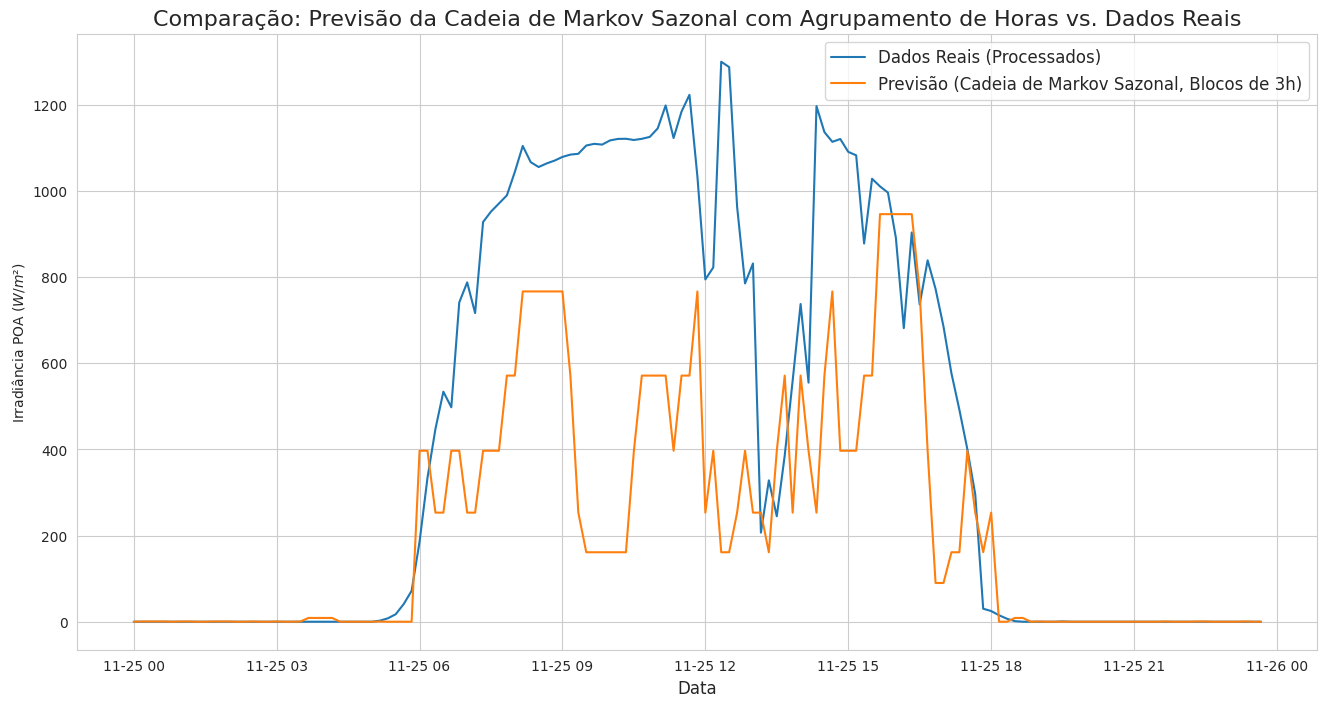


Visualização da previsão (agrupamento de horas) concluída.


In [ ]:
# --- VISUALIZAR A PREVISÃO (Cadeia de Markov Sazonal com Agrupamento de Horas) ---
print("\n" + "-"*50)
print("--- VISUALIZANDO A PREVISÃO (Cadeia de Markov Sazonal com Agrupamento de Horas) ---")
print("-"*50)

# Verificar se as séries simulada e real processada existem e não estão vazias
if ('simulated_poa_series_seasonal_grouped' in locals() or 'simulated_poa_series_seasonal_grouped' in globals()) and \
   ('real_poa_processed' in locals() or 'real_poa_processed' in globals()):

    if simulated_poa_series_seasonal_grouped is not None and not simulated_poa_series_seasonal_grouped.empty and \
       real_poa_processed is not None and not real_poa_processed.empty:

        # Alinhar as séries para plotagem (usando inner join para mostrar apenas o período de previsão com dados reais)
        simulated_aligned_plot, real_aligned_plot = simulated_poa_series_seasonal_grouped.align(real_poa_processed, join='inner')

        if simulated_aligned_plot.empty or real_aligned_plot.empty:
             print("\nAviso: Não há pontos de dados alinhados para plotar a comparação da previsão com agrupamento de horas e os dados reais.")
        else:
            print("\n[Visualização] Gerando gráfico de comparação da previsão com agrupamento de horas.")

            plt.figure(figsize=(16, 8))
            # Plotando os últimos N dias de dados observados antes da previsão
            plot_days_hist = 0 # Reutilizar plot_days_hist se existir, caso contrário, definir um valor padrão
            # if 'subset_data' in locals() or 'subset_data' in globals():
            #      plt.plot(subset_data.last(f'{plot_days_hist}D'), label='Observado (Últimos 7 Dias)')
            # else:
            #      print("\nAviso: Série 'subset_data' não encontrada para plotar histórico. Plotando apenas o período de previsão.")
            #      # Apenas plotar o período de previsão se o histórico não estiver disponível

            plt.plot(real_aligned_plot, label='Dados Reais (Processados)')
            # Tentar usar hour_block_size se existir, caso contrário, usar um rótulo genérico
            plot_label = f'Previsão (Cadeia de Markov Sazonal, Blocos de {hour_block_size}h)' if 'hour_block_size' in locals() else 'Previsão (Cadeia de Markov Sazonal Agrupada)'
            plt.plot(simulated_aligned_plot, label=plot_label)

            plt.title(f'Comparação: Previsão da Cadeia de Markov Sazonal com Agrupamento de Horas vs. Dados Reais', fontsize=16)
            plt.xlabel('Data', fontsize=12)
            plt.ylabel('Irradiância POA ($W/m²$)')
            plt.legend(fontsize=12)
            plt.show()

            print("\nVisualização da previsão (agrupamento de horas) concluída.")

    else:
        print("\nA série simulada com agrupamento de horas ou a série de dados reais processados está vazia. Impossível gerar o gráfico de comparação.")
else:
    print("\nVariáveis de previsão simulada ou dados reais processados não encontradas. Impossível gerar o gráfico de comparação.")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Check if real_poa_processed is available and not empty
if 'real_poa_processed' in locals() or 'real_poa_processed' in globals():
    if real_poa_processed is not None and not real_poa_processed.empty:
        # Calculate the average real irradiance during the forecast period for percentage calculation
        average_real_irradiance = real_poa_processed.mean()

        print("\nComparação das Métricas de Avaliação:")
        print("-" * 40)
        print(f"Referência para Erro Percentual: Média da Irradiância Real no Período de Previsão = {average_real_irradiance:.4f} W/m²")
        print("-" * 40)

        # Print the evaluation metrics for comparison
        print(f"Cadeia de Markov Não Sazonal:")
        print(f"  RMSE: {rmse:.4f} ({rmse/average_real_irradiance:.2%})")
        print(f"  MAE:  {mae:.4f} ({mae/average_real_irradiance:.2%})")
        print("-" * 40)

        # Check if seasonal metrics exist
        if 'rmse_seasonal' in locals() and 'mae_seasonal' in locals():
            print(f"Cadeia de Markov Sazonal (Hourly Matrices, {discretized_data_seasonal.nunique()} Estados):")
            print(f"  RMSE: {rmse_seasonal:.4f} ({rmse_seasonal/average_real_irradiance:.2%})")
            print(f"  MAE:  {mae_seasonal:.4f} ({mae_seasonal/average_real_irradiance:.2%})")
            print("-" * 40)
        else:
            print("Métricas para Cadeia de Markov Sazonal (Hourly Matrices) não encontradas.")
            print("-" * 40)

        # Check if seasonal grouped metrics exist
        if 'rmse_seasonal_grouped' in locals() and 'mae_seasonal_grouped' in locals() and 'hour_block_size' in locals():
            print(f"Cadeia de Markov Sazonal (Hour Grouping, Blocos de {hour_block_size}h):")
            print(f"  RMSE: {rmse_seasonal_grouped:.4f} ({rmse_seasonal_grouped/average_real_irradiance:.2%})")
            print(f"  MAE:  {mae_seasonal_grouped:.4f} ({mae_seasonal_grouped/average_real_irradiance:.2%})")
            print("-" * 40)
        else:
            print("Métricas para Cadeia de Markov Sazonal (Hour Grouping) não encontradas.")
            print("-" * 40)


        # Compare the metrics and note which model performed best for each metric
        print("\nResumo da Comparação:")

        # Create dictionaries of metrics for easier comparison
        rmse_metrics = {}
        mae_metrics = {}

        rmse_metrics['Não Sazonal'] = rmse
        mae_metrics['Não Sazonal'] = mae

        if 'rmse_seasonal' in locals() and 'mae_seasonal' in locals():
             rmse_metrics['Sazonal (Hourly)'] = rmse_seasonal
             mae_metrics['Sazonal (Hourly)'] = mae_seasonal

        if 'rmse_seasonal_grouped' in locals() and 'mae_seasonal_grouped' in locals():
             rmse_metrics['Sazonal (Hour Grouping)'] = rmse_seasonal_grouped
             mae_metrics['Sazonal (Hour Grouping)'] = mae_seasonal_grouped


        # Find the model with the minimum RMSE
        if rmse_metrics: # Check if dictionary is not empty
            best_rmse_model_name = min(rmse_metrics, key=rmse_metrics.get)
            best_rmse_value = rmse_metrics[best_rmse_model_name]
            print(f"Melhor Modelo (Menor RMSE): {best_rmse_model_name} (RMSE: {best_rmse_value:.4f} / {best_rmse_value/average_real_irradiance:.2%})")
        else:
            print("Não há métricas de RMSE disponíveis para comparação.")

        # Find the model with the minimum MAE
        if mae_metrics: # Check if dictionary is not empty
            best_mae_model_name = min(mae_metrics, key=mae_metrics.get)
            best_mae_value = mae_metrics[best_mae_model_name]
            print(f"Melhor Modelo (Menor MAE):  {best_mae_model_name} (MAE: {best_mae_value:.4f} / {best_mae_value/average_real_irradiance:.2%})")
        else:
            print("Não há métricas de MAE disponíveis para comparação.")

    else:
        print("\nA série 'real_poa_processed' está vazia. Não é possível calcular métricas percentuais.")
else:
    print("\nA série 'real_poa_processed' não foi encontrada. Não é possível calcular métricas percentuais.")


A série 'real_poa_processed' não foi encontrada. Não é possível calcular métricas percentuais.
